# ECE 4420/6420 Final Project
## Tabular Playground Series: State Classification
### Brittney McKeone, Harshal Varpe, Steven Platt, Zach Fugate 


For the final project, we chose a Kaggle competition named Tabular Playground Series. The final project aimed at the implementation various EDA and data preprocessing methods, classifiers, and their respective hypertuning to a classification problem.

The problem we chose concerned with binary state classification using biological sensor data collected from nearly a thousand different paticipant.

Project checkpoint 1 (15%): For this milestone, you will need to have downloaded the data, and
also run some initial pre-processing on it. You should also make at least one dummy submission
(all-positive, all-negative, most-frequency) on Kaggle and submit the Jupyter Notebook including
the code and a screenshot of the score on Canvas.

In [1]:
# Importing all the required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
import graphviz
import IPython
import mglearn
from IPython.display import HTML, display

import warnings
warnings.filterwarnings('ignore')

C:\Users\hvarp\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# We use this function provided during class/assignment to get the cross validation score and see if the model is overfitting.
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

Let us take a look at the data provided.

The dataset had three different data sets.
The "train.csv" file contains the sequence and corresponding sensor data. Each sequence has 60 data points or sensor readings. There are total 12 different sensors. Moreover, each sequence number is associated with a unique subject. The variable "step" is simply a counter that runs from 0 to 59 for each sequence or each subject. Important thing about this datafile is that there are no labels included. The image below shows a snippet of the .csv file.

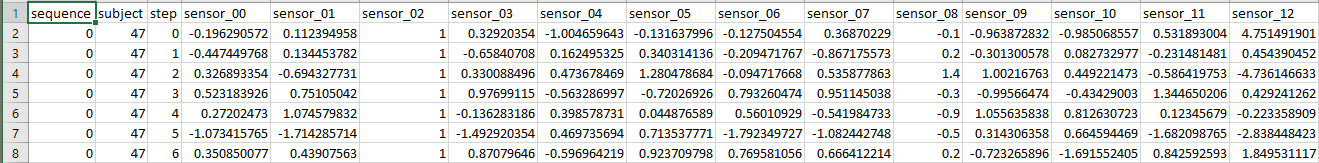

In [3]:
X_train = pd.read_csv("train.csv")
X_train_og = X_train # we will need this for heatmap and pairplot
X_train.shape

(1558080, 16)

In [4]:
X_train.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359


The "train_lables.csv" file contains the labels for the all the datapoints in "train.csv". It has only two columns: sequence and state.

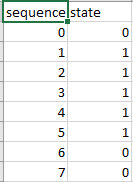

In [5]:
y_train = pd.read_csv("train_labels.csv")
y_train.head()

,sequence,state
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


In [6]:
y_train.shape

(25968, 2)

In [7]:
X_train.describe()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
count,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06,1.558080e+06
mean,1.298350e+04,3.316331e+02,2.950000e+01,4.365526e-04,-1.034982e-03,-2.178045e-01,-2.156555e-03,-1.828903e-03,-1.651785e-03,-4.122917e-04,-2.620665e-05,-1.298393e-04,1.365584e-03,3.315801e-04,-3.733291e-03,-1.172605e-02
std,7.496318e+03,1.958257e+02,1.731811e+01,2.658684e+00,4.404200e+00,2.298002e+00,3.934184e+00,1.683685e+00,1.590818e+00,3.345143e+00,3.243428e+00,4.501534e+00,2.592913e+00,1.917333e+00,4.532568e+00,3.911767e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-3.750634e+02,-4.345977e+02,-3.165948e+01,-4.083761e+02,-2.362601e+01,-7.498280e+01,-4.705046e+02,-4.070115e+02,-5.361000e+02,-2.703468e+02,-4.341271e+01,-4.270586e+02,-6.125494e+02
25%,6.491750e+03,1.617500e+02,1.475000e+01,-5.000000e-01,-4.831933e-01,-6.461531e-01,-4.929204e-01,-4.729928e-01,-4.786836e-01,-4.927140e-01,-5.022901e-01,-5.000000e-01,-5.151734e-01,-4.787939e-01,-4.835391e-01,-5.805627e-01
50%,1.298350e+04,3.350000e+02,2.950000e+01,-3.091190e-03,3.151261e-03,0.000000e+00,0.000000e+00,-1.589577e-03,2.991773e-03,9.107468e-04,-2.290076e-03,0.000000e+00,-1.445087e-03,-1.655822e-03,3.086420e-03,0.000000e+00
75%,1.947525e+04,5.010000e+02,4.425000e+01,4.845440e-01,4.926471e-01,3.338469e-01,4.893805e-01,4.701565e-01,5.056096e-01,4.927140e-01,4.847328e-01,5.000000e-01,5.086705e-01,4.780386e-01,4.938272e-01,5.703325e-01
max,2.596700e+04,6.710000e+02,5.900000e+01,3.358246e+02,4.495914e+02,1.666667e+00,4.366504e+02,2.487286e+01,7.791548e+01,4.425009e+02,3.312542e+02,6.301000e+02,3.679812e+02,4.186559e+01,4.480206e+02,6.305111e+02


In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1558080 entries, 0 to 1558079
Data columns (total 16 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   sequence   1558080 non-null  int64  
 1   subject    1558080 non-null  int64  
 2   step       1558080 non-null  int64  
 3   sensor_00  1558080 non-null  float64
 4   sensor_01  1558080 non-null  float64
 5   sensor_02  1558080 non-null  float64
 6   sensor_03  1558080 non-null  float64
 7   sensor_04  1558080 non-null  float64
 8   sensor_05  1558080 non-null  float64
 9   sensor_06  1558080 non-null  float64
 10  sensor_07  1558080 non-null  float64
 11  sensor_08  1558080 non-null  float64
 12  sensor_09  1558080 non-null  float64
 13  sensor_10  1558080 non-null  float64
 14  sensor_11  1558080 non-null  float64
 15  sensor_12  1558080 non-null  float64
dtypes: float64(13), int64(3)
memory usage: 190.2 MB


Let us check if our dataset has any missing values.

In [9]:
cols = list(X_train.columns)
print(cols)

['sequence', 'subject', 'step', 'sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12']


In [10]:
bool_df = pd.DataFrame(columns=X_train.columns)
for i in cols:
    bool_df[i] = pd.isnull(X_train[i])
    print( np.unique(bool_df[i], return_counts=True) )

(array([False]), array([1558080], dtype=int64))
(array([False]), array([1558080], dtype=int64))
(array([False]), array([1558080], dtype=int64))
(array([False]), array([1558080], dtype=int64))
(array([False]), array([1558080], dtype=int64))
(array([False]), array([1558080], dtype=int64))
(array([False]), array([1558080], dtype=int64))
(array([False]), array([1558080], dtype=int64))
(array([False]), array([1558080], dtype=int64))
(array([False]), array([1558080], dtype=int64))
(array([False]), array([1558080], dtype=int64))
(array([False]), array([1558080], dtype=int64))
(array([False]), array([1558080], dtype=int64))
(array([False]), array([1558080], dtype=int64))
(array([False]), array([1558080], dtype=int64))
(array([False]), array([1558080], dtype=int64))


In [11]:
for i in cols:
    print(f" The number of non_null values for feature '{i}' : {(~bool_df[i]).values.sum()} ")

 The number of non_null values for feature 'sequence' : 1558080 
 The number of non_null values for feature 'subject' : 1558080 
 The number of non_null values for feature 'step' : 1558080 
 The number of non_null values for feature 'sensor_00' : 1558080 
 The number of non_null values for feature 'sensor_01' : 1558080 
 The number of non_null values for feature 'sensor_02' : 1558080 
 The number of non_null values for feature 'sensor_03' : 1558080 
 The number of non_null values for feature 'sensor_04' : 1558080 
 The number of non_null values for feature 'sensor_05' : 1558080 
 The number of non_null values for feature 'sensor_06' : 1558080 
 The number of non_null values for feature 'sensor_07' : 1558080 
 The number of non_null values for feature 'sensor_08' : 1558080 
 The number of non_null values for feature 'sensor_09' : 1558080 
 The number of non_null values for feature 'sensor_10' : 1558080 
 The number of non_null values for feature 'sensor_11' : 1558080 
 The number of non

The ".isnull" function is used check if any value in the particular column / series / feature is not missing values. This function/method returns boolean values. All these values are stored in the another dataframe "bool_df". If there are no missing values, then the series for each feature will contain only false values.

The "np.unique()" function is used to count if there are any True values. As we can see from the results above, there is only one unique values that is False. 

Just to be sure, we also use "~pd.values.sum()" to check the number of False values. It should match with our number of datapoints i.e. 1558080. Without the ~ sign the values or count of True values is returned.

In [12]:
X_train[cols].isna().sum()

sequence     0
subject      0
step         0
sensor_00    0
sensor_01    0
sensor_02    0
sensor_03    0
sensor_04    0
sensor_05    0
sensor_06    0
sensor_07    0
sensor_08    0
sensor_09    0
sensor_10    0
sensor_11    0
sensor_12    0
dtype: int64

Another way to check if the dataset has null values or missing values is to use `df.isna().sum()`. This gives us the total number of missing values. As we can see from the cell above none of the features have missing values.

In [13]:
X_train = X_train.drop(columns=['subject','step'])
X_train = X_train.groupby(['sequence']).mean()
y_seq = y_train['sequence']
y_train = y_train.drop(columns=['sequence'])

In [14]:
dc = DummyClassifier()
result_dict = {} 
dc.fit(X_train,y_train)

DummyClassifier()

We also need to check if the testing set has any missing values.

In [15]:
X_test = pd.read_csv("test.csv")
X_test_og = X_test # we may need this for heatmap and pariplot
X_test = X_test.drop(columns=['subject','step'])
X_test.isna().sum()

sequence     0
sensor_00    0
sensor_01    0
sensor_02    0
sensor_03    0
sensor_04    0
sensor_05    0
sensor_06    0
sensor_07    0
sensor_08    0
sensor_09    0
sensor_10    0
sensor_11    0
sensor_12    0
dtype: int64

From the result above, we can conclude that we do not have any missgin values in the testing set.

It is necessary to group the test set by sequence number just like we did it for training set.

In [16]:
X_test = X_test.groupby(['sequence']).mean() 
# X_test
predict_dc = dc.predict(X_test)
predict_dc_df = pd.DataFrame(predict_dc,columns=['state']) # creating a dataframe of the results
# predict_df

The following cell was created to create a dataframe with correct sequence numbers. Later in the execution this dataframe is merged with state prediction by each model.

In [17]:
list = []
i = 1
while i < 12219:
    list.append(25967+i)
    i += 1
col = np.array(list)
col_df = pd.DataFrame(col,columns=['sequence']) # creating a dataframe for sequence numbers. This df will be the same for
# all classifiers.
# col_df

final_dc_df = pd.concat([col_df,predict_dc_df],ignore_index=False, sort=False,axis=1) # concating the 
# final_df

In [18]:
final_dc_df.to_csv("Results/output_dummy.csv",index=False) # output the result to csv file

result_dict["Dummy_Classifer"] = mean_std_cross_val_scores(dc, X_train, y_train, cv=5, return_train_score=True)

### Decision Tree Classifier

In [19]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train,y_train)
predict_dtc = dtc.predict(X_test)
predict_dtc_df = pd.DataFrame(predict_dtc,columns=['state']) # creating a dataframe of the results

In [20]:
final_dtc_df = pd.concat([col_df,predict_dtc_df],ignore_index=False, sort=False,axis=1)
final_dtc_df.to_csv("Results/output_dtc.csv",index=False)
result_dict["DecitionTree_Classifier"] = mean_std_cross_val_scores(dtc, X_train, y_train, cv=5, return_train_score=True)

### More Prepocessing

Initially, for the project checkpoint 1, we only checked for the null/missing values and tested the result of Dummy and Decision Tree Classifier. Meanwhile, we thought of more preprocessing that we could do. Thus we checked if the features are correlated. Although, it seems logical to assume that no two sensors can affect each other, it is quite possible that they may have some correlation between them.

We will try to create a heatmap  of the data to see correlation.

In [21]:
import seaborn as sns

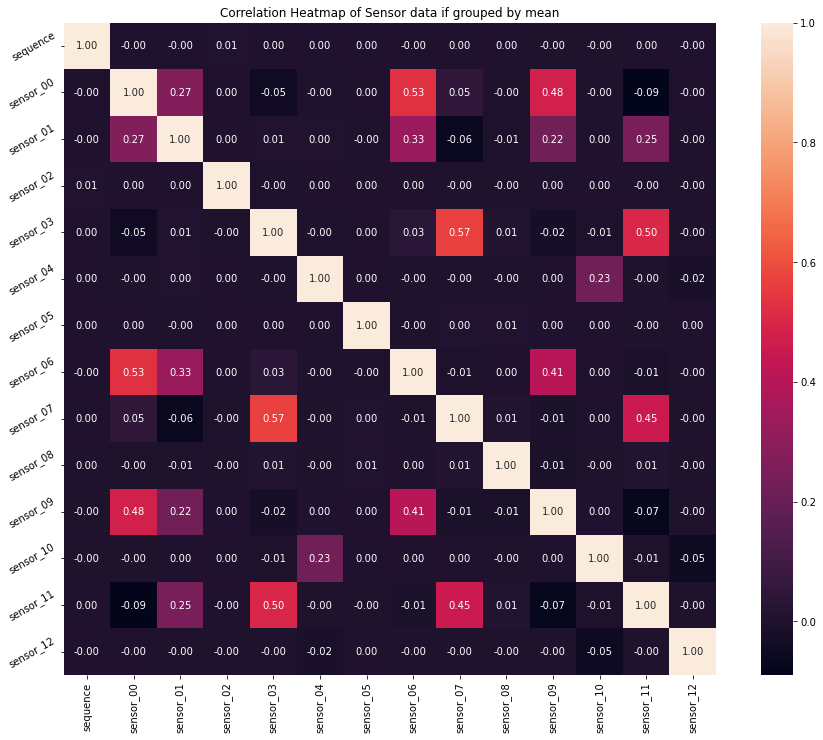

In [22]:
X_train_og = X_train_og.drop(columns=['subject','step'])
# X_train_og
X_train_og.groupby(['sequence']).mean()
correlation = X_train_og.corr()

plt.figure(figsize=(16,12))
plt.title('Correlation Heatmap of Sensor data if grouped by mean')
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
plt.show()

As we can see from the sensor heatmap, most sensors do not have significant correlation with each other. Sensors with correlation between 0.2 and 0.55, can be attributes to sensor noise. 

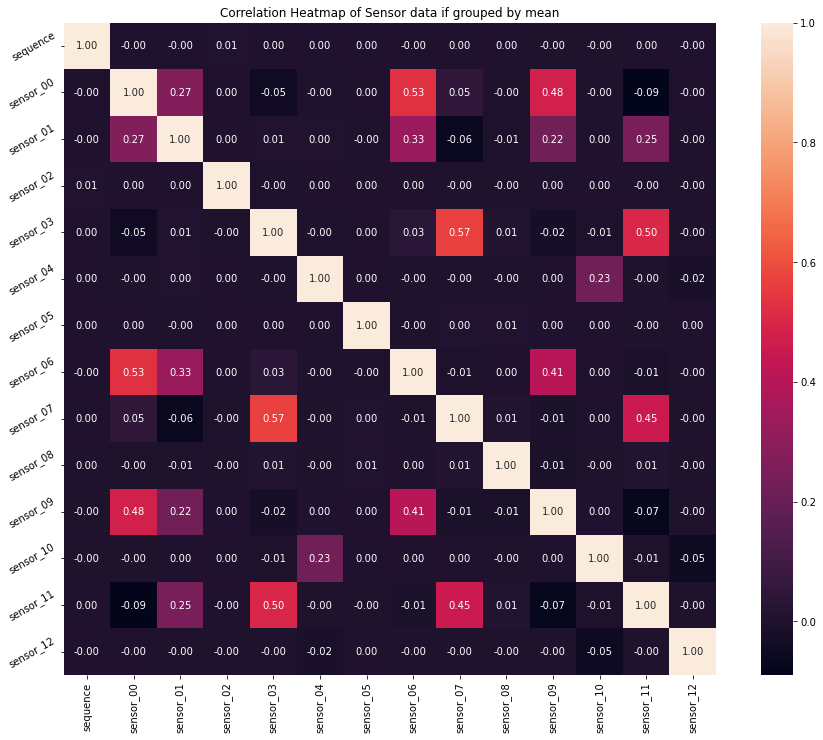

In [23]:
X_train_og.groupby(['sequence']).median()
correlation = X_train_og.corr()

plt.figure(figsize=(16,12))
plt.title('Correlation Heatmap of Sensor data if grouped by mean')
ax = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=30)           
plt.show()

There is no difference if we group the data by mean or median. Hence it is safe to assume that classifier behaviour won't change much.
Generally, with numerical data, we can do a interquartile analysis to see if the outliers should be included in the training set or not. With that in mind, we plotted the interquartile plot for each sensor. However, the operating range of the sensors were not provided. Hence, this analysis was not useful to us.

In [24]:
cols_og = X_train_og.columns.values.tolist()
cols_og.remove('sequence')
print(cols_og)

['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12']


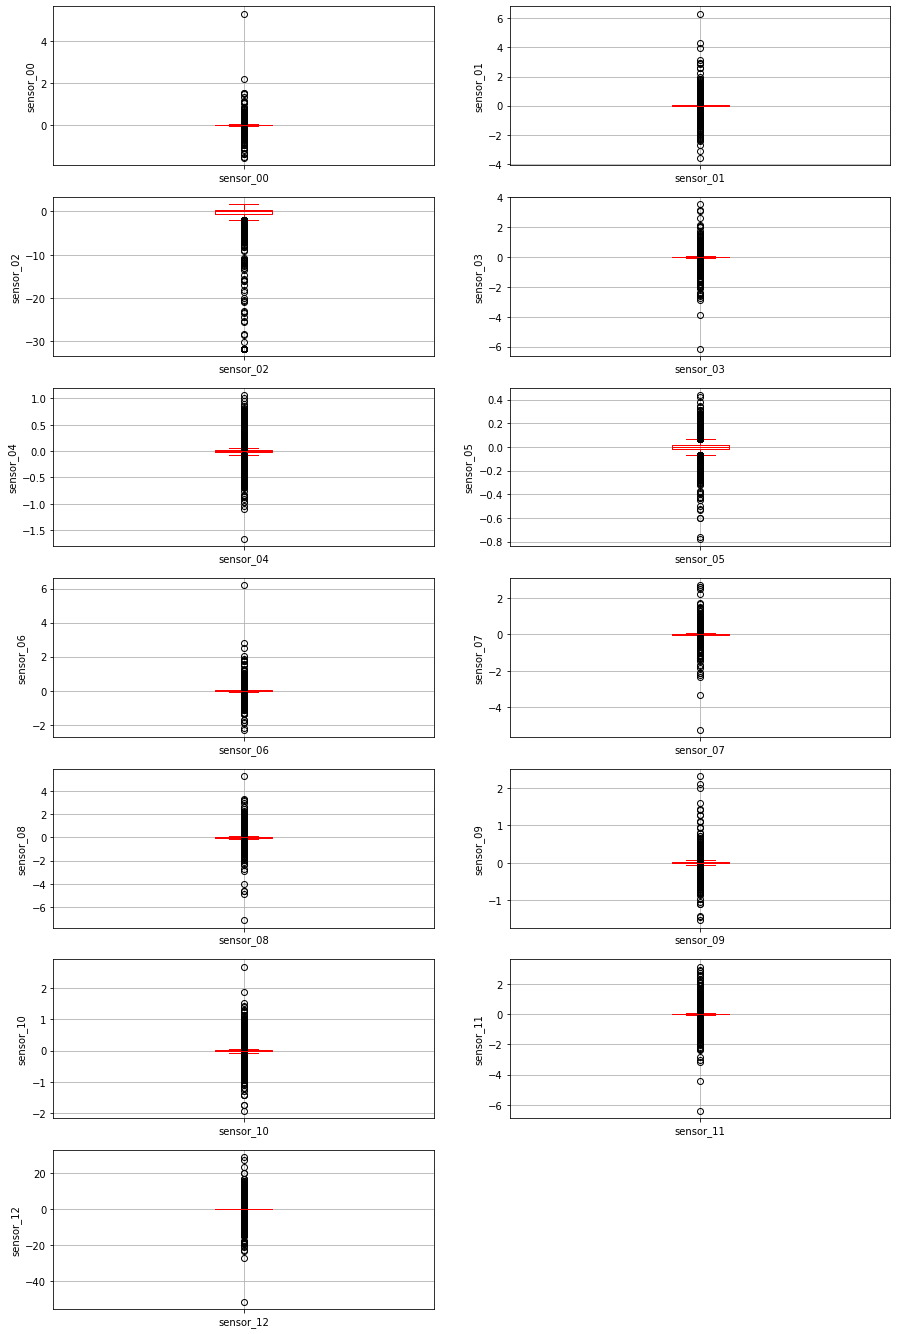

In [25]:
plt.figure(figsize=(15,45))
for count, value in enumerate(cols[3:]):
    plt.subplot(13, 2, count+1)
    fig = X_train.boxplot(column = value,color=dict(boxes='r', whiskers='r', medians='r', caps='r'))
    fig.set_title('')
    fig.set_ylabel(value)

In [26]:
## Did not end up using this. Computationally too expensive
## This was to plot a frequency histogram of the data.
# %matplotlib notebook
# a = X_train_og[cols_og[1]].value_counts(bins=800,sort=False).to_frame()
# a.plot()
# plt.xticks(rotation=60);
# plt.subplots_adjust(top=0.925, 
#                     bottom=0.30, 
#                     left=0.2, 
#                     right=0.90, 
#                     hspace=0.01, 
#                     wspace=0.01)
# plt.show()

The cell above shows the code that was written for plotting frequency histogram of the data. However, with over a million data points this cell was computationally quite heacy even when run on Palmetto Cluster.

### Preprocessing: Pratt Method

In [27]:
# ### Train Data
# rowNames = ["mean","std","min","25%","50%","75%","max"]
# describeDict = {}
# for sensorNum in range(13):
#     for rowName in rowNames:
#         describeDict[f"sensor_{str(sensorNum).zfill(2)}_{rowName}"] = []
# for numSequence in range(max(X_train["sequence"])+1):
#     info = X_train[X_train["sequence"]==numSequence].describe()
#     for sensorNum in range(13):
#         for rowName in rowNames:
#             describeDict[f"sensor_{str(sensorNum).zfill(2)}_{rowName}"].append(info[f"sensor_{str(sensorNum).zfill(2)}"][rowName])
#     if(numSequence%10==0):
#         print(numSequence)
# describeDict

# splatt_train_df = pd.DataFrame.from_dict(describeDict)
# splatt_train_df

In [28]:
# testDict = {}
# for sensorNum in range(13):
#     for rowName in rowNames:
#         testDict[f"sensor_{str(sensorNum).zfill(2)}_{rowName}"] = []
# for numSequence in range(25968,38186):#max(X_test["sequence"])+1-min(X_test["sequence"])):
#     info = X_test[X_test["sequence"]==numSequence].describe()
#     for sensorNum in range(13):
#         for rowName in rowNames:
#             testDict[f"sensor_{str(sensorNum).zfill(2)}_{rowName}"].append(info[f"sensor_{str(sensorNum).zfill(2)}"][rowName])
#     if(numSequence%100==0):
#         print(numSequence)
# testDict
# splatt_test_df = pd.DataFrame.from_dict(testDict)
# splatt_test_df

We had a unique idea to use the statistical information about the given data. The idea was to use features like mean, standard deviation, variance, 25%, 50%, 75% and max to split each sensor. Meaning instead of original 13 sensor readings, we now use 7 statistical feature for each sensor per sensor, so total of 91 distinct features.

The first cell above gives us the 91 feature dataframe for train dataset and the second cell gives the 91 feature dataframe for test dataset. These dataframes then could be used in the models. We discuss the results of using dataframes over other dataframes later in this report/jupyter notebook.

## Other Classfiers

After the interquartile analysis, we decided upon the model that we wanted try for our classification problem. The model we chose were :  Decision Tree Classifier, Gaussian Naive Bayes, Logistic Regression, Random Forest, Gradient Boosting, and CatBoost.
Decision Tree is very commom classifier that is used in classification problem. Gaussian Naive Bayes classifier applies the Bayes' theorem to the data with the assumption that there is no correlation between the different features.Although, our heatmap showed reletively low correlation, we wanted to see if we could get the best result from assumming zero correlation. Logistic Regression is another common model used in classification problems, such email spam classification problem. Then the rest three models are part of ensemble techniques that are known to perform much better than the other classifiers mentioned.

In [29]:
pd.DataFrame(result_dict).T

,fit_time,score_time,test_score,train_score
Dummy_Classifer,0.002 (+/- 0.001),0.000 (+/- 0.000),0.501 (+/- 0.000),0.501 (+/- 0.000)
DecitionTree_Classifier,0.355 (+/- 0.033),0.004 (+/- 0.002),0.612 (+/- 0.005),1.000 (+/- 0.000)


We can see that Decision tree classifier is overfitting. Let us try different models and see if we see better test scores and train scores.
#### Naive Bayes
Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable.

In [30]:
#Naive bayes
gnb = GaussianNB()
gnb.fit(X_train,y_train)
predict_gnb = gnb.predict(X_test)
predict_gnb_df = pd.DataFrame(predict_gnb,columns=['state']) # creating a dataframe of the results

final_gnb_df = pd.concat([col_df,predict_gnb_df],ignore_index=False, sort=False,axis=1)
final_gnb_df.to_csv("Results/output_gnb.csv",index=False)
result_dict["GNB_Classifier"] = mean_std_cross_val_scores(gnb, X_train, y_train, cv=5, return_train_score=True)

In [31]:
pd.DataFrame(result_dict).T

,fit_time,score_time,test_score,train_score
Dummy_Classifer,0.002 (+/- 0.001),0.000 (+/- 0.000),0.501 (+/- 0.000),0.501 (+/- 0.000)
DecitionTree_Classifier,0.355 (+/- 0.033),0.004 (+/- 0.002),0.612 (+/- 0.005),1.000 (+/- 0.000)
GNB_Classifier,0.007 (+/- 0.001),0.002 (+/- 0.000),0.601 (+/- 0.008),0.602 (+/- 0.009)


#### Logistic Regression

In [32]:
#Logistic Regression
lr = LogisticRegression(random_state=1)
lr.fit(X_train,y_train)
predict_lr = lr.predict(X_test)
predict_lr_df = pd.DataFrame(predict_lr,columns=['state']) # creating a dataframe of the results

final_lr_df = pd.concat([col_df,predict_lr_df],ignore_index=False, sort=False,axis=1)
final_lr_df.to_csv("Results/output_lr.csv",index=False)
result_dict["LogisticR_Classifier"] = mean_std_cross_val_scores(lr, X_train, y_train, cv=5, return_train_score=True)

In [33]:
pd.DataFrame(result_dict).T

,fit_time,score_time,test_score,train_score
Dummy_Classifer,0.002 (+/- 0.001),0.000 (+/- 0.000),0.501 (+/- 0.000),0.501 (+/- 0.000)
DecitionTree_Classifier,0.355 (+/- 0.033),0.004 (+/- 0.002),0.612 (+/- 0.005),1.000 (+/- 0.000)
GNB_Classifier,0.007 (+/- 0.001),0.002 (+/- 0.000),0.601 (+/- 0.008),0.602 (+/- 0.009)
LogisticR_Classifier,0.051 (+/- 0.004),0.001 (+/- 0.001),0.547 (+/- 0.006),0.548 (+/- 0.002)


#### Random Forest Classifier

In [34]:
#Random Forest
rf = RandomForestClassifier(n_estimators = 100, max_depth=10, random_state=0)
rf.fit(X_train,y_train)

predict_rf = rf.predict(X_test)
predict_rf_df = pd.DataFrame(predict_rf,columns=['state']) # creating a dataframe of the results

final_rf_df = pd.concat([col_df,predict_rf_df],ignore_index=False, sort=False,axis=1)
final_rf_df.to_csv("Results/output_rf.csv",index=False)
result_dict["RandomForest_Classifier"] = mean_std_cross_val_scores(rf, X_train, y_train, cv=5, return_train_score=True)

In [35]:
pd.DataFrame(result_dict).T

,fit_time,score_time,test_score,train_score
Dummy_Classifer,0.002 (+/- 0.001),0.000 (+/- 0.000),0.501 (+/- 0.000),0.501 (+/- 0.000)
DecitionTree_Classifier,0.355 (+/- 0.033),0.004 (+/- 0.002),0.612 (+/- 0.005),1.000 (+/- 0.000)
GNB_Classifier,0.007 (+/- 0.001),0.002 (+/- 0.000),0.601 (+/- 0.008),0.602 (+/- 0.009)
LogisticR_Classifier,0.051 (+/- 0.004),0.001 (+/- 0.001),0.547 (+/- 0.006),0.548 (+/- 0.002)
RandomForest_Classifier,4.344 (+/- 0.185),0.069 (+/- 0.017),0.701 (+/- 0.006),0.786 (+/- 0.002)


#### Gradient Boosting Classifier

In [36]:
#Gradient Boosting
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0)
gbc.fit(X_train,y_train)

predict_gbc = gbc.predict(X_test)
predict_gbc_df = pd.DataFrame(predict_gbc,columns=['state']) # creating a dataframe of the results

final_gbc_df = pd.concat([col_df,predict_gbc_df],ignore_index=False, sort=False,axis=1)
final_gbc_df.to_csv("Results/output_gbc.csv",index=False)
result_dict["GradBoost_Classifier"] = mean_std_cross_val_scores(gbc, X_train, y_train, cv=5, return_train_score=True)

In [37]:
pd.DataFrame(result_dict).T

,fit_time,score_time,test_score,train_score
Dummy_Classifer,0.002 (+/- 0.001),0.000 (+/- 0.000),0.501 (+/- 0.000),0.501 (+/- 0.000)
DecitionTree_Classifier,0.355 (+/- 0.033),0.004 (+/- 0.002),0.612 (+/- 0.005),1.000 (+/- 0.000)
GNB_Classifier,0.007 (+/- 0.001),0.002 (+/- 0.000),0.601 (+/- 0.008),0.602 (+/- 0.009)
LogisticR_Classifier,0.051 (+/- 0.004),0.001 (+/- 0.001),0.547 (+/- 0.006),0.548 (+/- 0.002)
RandomForest_Classifier,4.344 (+/- 0.185),0.069 (+/- 0.017),0.701 (+/- 0.006),0.786 (+/- 0.002)
GradBoost_Classifier,2.975 (+/- 0.139),0.009 (+/- 0.006),0.685 (+/- 0.005),0.692 (+/- 0.001)


### More Preprocessing

At this stage, we thought that we might be able to improve the performance all the baselines estimators by scaling the data. Hence, we used StandardScaler to scale the data. However, we did not get a better score when the result were uploaded to the Kaggle competition.
    
   The code is given in the cells below. It is commented out, since we did not use it at all.

In [38]:
std_scale = StandardScaler()
answer = std_scale.fit_transform(X_train)
answer = pd.DataFrame(answer)
answer.columns = X_train.columns
# answer = answer.drop(columns=["subject","step"]) # MAY NOT NEED THIS LINE SINCE I ALREADY REMOVED THESE COLUMNS IN UPPER CELLS.
# answer # X_train

# THIS CELL GIVES A DATAFRAME WITH SCALED TRAIN DATA.

In [39]:
answer_t = std_scale.fit_transform(X_test)
answer_t = pd.DataFrame(answer_t)
# answer_t = answer_t.drop(columns=[0,1])# MAY NOT NEED THIS LINE SINCE I ALREADY REMOVED THESE COLUMNS IN UPPER CELLS.
answer_t.columns = X_train.columns
# answer_t # X_test

# THIS CELL GIVED A DATAFRAME WITH SCALED TEST DATA.

In [40]:
# #Random Forest
rf = RandomForestClassifier(n_estimators = 100, max_depth=10, random_state=0)
rf.fit(answer,y_train)

predict_rf = rf.predict_proba(answer_t)
predict_rf_proba = []
for i in range(len(predict_rf)):
    predict_rf_proba.append(predict_rf[i][1])
    
predict_rf_df = pd.DataFrame(predict_rf_proba,columns=['state']) # creating a dataframe of the results

final_rf_df = pd.concat([col_df,predict_rf_df],ignore_index=False, sort=False,axis=1)
final_rf_df.to_csv("output_rf_predict_proba_scaled.csv",index=False)
result_dict["RandomForest_Classifier_predict_proba_scaled"] = mean_std_cross_val_scores(rf, answer, y_train, cv=5, return_train_score=True)

### Testing the performance of predict_proba

In [41]:
#Gradient Boosting
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0)
gbc.fit(X_train,y_train)

predict_gbc = gbc.predict_proba(X_test)
predict_gbc_proba = []
for i in range(len(predict_gbc)):
    predict_gbc_proba.append(predict_gbc[i][1])

predict_gbc_df = pd.DataFrame(predict_gbc_proba,columns=['state']) # creating a dataframe of the results
final_gbc_df = pd.concat([col_df,predict_gbc_df],ignore_index=False, sort=False,axis=1)
final_gbc_df.to_csv("Results/output_gbc_proba.csv",index=False)


result_dict["GradBoost_Classifier_predict_proba"] = mean_std_cross_val_scores(gbc, X_train, y_train, cv=5, return_train_score=True)
pd.DataFrame(result_dict).T

,fit_time,score_time,test_score,train_score
Dummy_Classifer,0.002 (+/- 0.001),0.000 (+/- 0.000),0.501 (+/- 0.000),0.501 (+/- 0.000)
DecitionTree_Classifier,0.355 (+/- 0.033),0.004 (+/- 0.002),0.612 (+/- 0.005),1.000 (+/- 0.000)
GNB_Classifier,0.007 (+/- 0.001),0.002 (+/- 0.000),0.601 (+/- 0.008),0.602 (+/- 0.009)
LogisticR_Classifier,0.051 (+/- 0.004),0.001 (+/- 0.001),0.547 (+/- 0.006),0.548 (+/- 0.002)
RandomForest_Classifier,4.344 (+/- 0.185),0.069 (+/- 0.017),0.701 (+/- 0.006),0.786 (+/- 0.002)
GradBoost_Classifier,2.975 (+/- 0.139),0.009 (+/- 0.006),0.685 (+/- 0.005),0.692 (+/- 0.001)
RandomForest_Classifier_predict_proba_scaled,4.369 (+/- 0.233),0.067 (+/- 0.013),0.701 (+/- 0.006),0.786 (+/- 0.002)
GradBoost_Classifier_predict_proba,2.321 (+/- 0.112),0.004 (+/- 0.001),0.685 (+/- 0.005),0.692 (+/- 0.001)


In [42]:
#Random Forest
rf = RandomForestClassifier(n_estimators = 100, max_depth=10, random_state=0)
rf.fit(X_train,y_train)

predict_rf = rf.predict_proba(X_test)
predict_rf_proba = []
for i in range(len(predict_rf)):
    predict_rf_proba.append(predict_rf[i][1])
    
predict_rf_df = pd.DataFrame(predict_rf_proba,columns=['state']) # creating a dataframe of the results

final_rf_df = pd.concat([col_df,predict_rf_df],ignore_index=False, sort=False,axis=1)
final_rf_df.to_csv("Results/output_rf_predict_proba.csv",index=False)
result_dict["RandomForest_Classifier_predict_proba"] = mean_std_cross_val_scores(rf, X_train, y_train, cv=5, return_train_score=True)

In [43]:
pd.DataFrame(result_dict).T

,fit_time,score_time,test_score,train_score
Dummy_Classifer,0.002 (+/- 0.001),0.000 (+/- 0.000),0.501 (+/- 0.000),0.501 (+/- 0.000)
DecitionTree_Classifier,0.355 (+/- 0.033),0.004 (+/- 0.002),0.612 (+/- 0.005),1.000 (+/- 0.000)
GNB_Classifier,0.007 (+/- 0.001),0.002 (+/- 0.000),0.601 (+/- 0.008),0.602 (+/- 0.009)
LogisticR_Classifier,0.051 (+/- 0.004),0.001 (+/- 0.001),0.547 (+/- 0.006),0.548 (+/- 0.002)
RandomForest_Classifier,4.344 (+/- 0.185),0.069 (+/- 0.017),0.701 (+/- 0.006),0.786 (+/- 0.002)
GradBoost_Classifier,2.975 (+/- 0.139),0.009 (+/- 0.006),0.685 (+/- 0.005),0.692 (+/- 0.001)
RandomForest_Classifier_predict_proba_scaled,4.369 (+/- 0.233),0.067 (+/- 0.013),0.701 (+/- 0.006),0.786 (+/- 0.002)
GradBoost_Classifier_predict_proba,2.321 (+/- 0.112),0.004 (+/- 0.001),0.685 (+/- 0.005),0.692 (+/- 0.001)
RandomForest_Classifier_predict_proba,3.153 (+/- 0.209),0.055 (+/- 0.010),0.701 (+/- 0.006),0.786 (+/- 0.002)


The kaggle score clearly improved when we used the predict_proba function. However, there were no changes in the model. In other words, the model was not improved in any sort of way. Since the task was provide classification and not the probabilities we decied not to pursue this path.

In [44]:
# CATboost
cb = CatBoostClassifier(random_state=0)
cb.fit(X_train,y_train)

predict_cb = cb.predict(X_test)
predict_cb_df = pd.DataFrame(predict_cb,columns=['state']) # creating a dataframe of the results

final_cb_df = pd.concat([col_df,predict_cb_df],ignore_index=False, sort=False,axis=1)
final_cb_df.to_csv("Results/output_catboost.csv",index=False)
result_dict["CATBoost_Classifier"] = mean_std_cross_val_scores(cb, X_train, y_train, cv=5, return_train_score=True)


Learning rate set to 0.04139
0:	learn: 0.6879476	total: 162ms	remaining: 2m 41s
1:	learn: 0.6832365	total: 167ms	remaining: 1m 23s
2:	learn: 0.6789200	total: 172ms	remaining: 57.3s
3:	learn: 0.6746342	total: 179ms	remaining: 44.5s
4:	learn: 0.6707278	total: 183ms	remaining: 36.5s
5:	learn: 0.6668593	total: 189ms	remaining: 31.2s
6:	learn: 0.6631236	total: 195ms	remaining: 27.6s
7:	learn: 0.6599042	total: 200ms	remaining: 24.8s
8:	learn: 0.6565385	total: 206ms	remaining: 22.6s
9:	learn: 0.6535577	total: 211ms	remaining: 20.8s
10:	learn: 0.6508196	total: 215ms	remaining: 19.3s
11:	learn: 0.6480229	total: 221ms	remaining: 18.2s
12:	learn: 0.6455043	total: 225ms	remaining: 17.1s
13:	learn: 0.6430186	total: 231ms	remaining: 16.3s
14:	learn: 0.6407470	total: 236ms	remaining: 15.5s
15:	learn: 0.6387911	total: 242ms	remaining: 14.9s
16:	learn: 0.6366498	total: 247ms	remaining: 14.3s
17:	learn: 0.6347020	total: 253ms	remaining: 13.8s
18:	learn: 0.6327167	total: 258ms	remaining: 13.3s
19:	learn:

187:	learn: 0.5518363	total: 1.26s	remaining: 5.43s
188:	learn: 0.5517251	total: 1.26s	remaining: 5.42s
189:	learn: 0.5515860	total: 1.27s	remaining: 5.41s
190:	learn: 0.5514027	total: 1.27s	remaining: 5.4s
191:	learn: 0.5512424	total: 1.28s	remaining: 5.38s
192:	learn: 0.5511068	total: 1.28s	remaining: 5.37s
193:	learn: 0.5509118	total: 1.29s	remaining: 5.36s
194:	learn: 0.5507383	total: 1.3s	remaining: 5.35s
195:	learn: 0.5505887	total: 1.3s	remaining: 5.34s
196:	learn: 0.5504408	total: 1.31s	remaining: 5.33s
197:	learn: 0.5501295	total: 1.31s	remaining: 5.32s
198:	learn: 0.5499583	total: 1.32s	remaining: 5.31s
199:	learn: 0.5497510	total: 1.32s	remaining: 5.3s
200:	learn: 0.5496589	total: 1.33s	remaining: 5.29s
201:	learn: 0.5494918	total: 1.34s	remaining: 5.28s
202:	learn: 0.5493010	total: 1.34s	remaining: 5.27s
203:	learn: 0.5490573	total: 1.35s	remaining: 5.26s
204:	learn: 0.5488502	total: 1.35s	remaining: 5.25s
205:	learn: 0.5486841	total: 1.36s	remaining: 5.24s
206:	learn: 0.54

379:	learn: 0.5209423	total: 2.35s	remaining: 3.83s
380:	learn: 0.5206010	total: 2.35s	remaining: 3.82s
381:	learn: 0.5204750	total: 2.36s	remaining: 3.81s
382:	learn: 0.5203606	total: 2.36s	remaining: 3.81s
383:	learn: 0.5202275	total: 2.37s	remaining: 3.8s
384:	learn: 0.5200954	total: 2.37s	remaining: 3.79s
385:	learn: 0.5200068	total: 2.38s	remaining: 3.78s
386:	learn: 0.5198789	total: 2.38s	remaining: 3.77s
387:	learn: 0.5197463	total: 2.39s	remaining: 3.77s
388:	learn: 0.5195177	total: 2.39s	remaining: 3.76s
389:	learn: 0.5193416	total: 2.4s	remaining: 3.75s
390:	learn: 0.5191937	total: 2.4s	remaining: 3.74s
391:	learn: 0.5190937	total: 2.41s	remaining: 3.74s
392:	learn: 0.5189224	total: 2.41s	remaining: 3.73s
393:	learn: 0.5188270	total: 2.42s	remaining: 3.72s
394:	learn: 0.5186953	total: 2.42s	remaining: 3.71s
395:	learn: 0.5185639	total: 2.43s	remaining: 3.71s
396:	learn: 0.5184760	total: 2.43s	remaining: 3.7s
397:	learn: 0.5183043	total: 2.44s	remaining: 3.69s
398:	learn: 0.51

550:	learn: 0.4982180	total: 3.25s	remaining: 2.65s
551:	learn: 0.4980315	total: 3.26s	remaining: 2.65s
552:	learn: 0.4979115	total: 3.27s	remaining: 2.64s
553:	learn: 0.4977686	total: 3.27s	remaining: 2.63s
554:	learn: 0.4976062	total: 3.27s	remaining: 2.63s
555:	learn: 0.4974874	total: 3.28s	remaining: 2.62s
556:	learn: 0.4973501	total: 3.29s	remaining: 2.61s
557:	learn: 0.4972448	total: 3.29s	remaining: 2.61s
558:	learn: 0.4971202	total: 3.3s	remaining: 2.6s
559:	learn: 0.4969456	total: 3.3s	remaining: 2.59s
560:	learn: 0.4968615	total: 3.31s	remaining: 2.59s
561:	learn: 0.4967744	total: 3.31s	remaining: 2.58s
562:	learn: 0.4967032	total: 3.32s	remaining: 2.58s
563:	learn: 0.4965755	total: 3.32s	remaining: 2.57s
564:	learn: 0.4964291	total: 3.33s	remaining: 2.56s
565:	learn: 0.4962979	total: 3.33s	remaining: 2.56s
566:	learn: 0.4961686	total: 3.34s	remaining: 2.55s
567:	learn: 0.4960894	total: 3.34s	remaining: 2.54s
568:	learn: 0.4959568	total: 3.35s	remaining: 2.54s
569:	learn: 0.4

721:	learn: 0.4795708	total: 4.17s	remaining: 1.61s
722:	learn: 0.4794674	total: 4.18s	remaining: 1.6s
723:	learn: 0.4793733	total: 4.18s	remaining: 1.59s
724:	learn: 0.4792666	total: 4.19s	remaining: 1.59s
725:	learn: 0.4792048	total: 4.19s	remaining: 1.58s
726:	learn: 0.4790890	total: 4.2s	remaining: 1.58s
727:	learn: 0.4790062	total: 4.2s	remaining: 1.57s
728:	learn: 0.4789001	total: 4.21s	remaining: 1.56s
729:	learn: 0.4787984	total: 4.21s	remaining: 1.56s
730:	learn: 0.4786690	total: 4.22s	remaining: 1.55s
731:	learn: 0.4785434	total: 4.22s	remaining: 1.55s
732:	learn: 0.4784918	total: 4.23s	remaining: 1.54s
733:	learn: 0.4784183	total: 4.23s	remaining: 1.53s
734:	learn: 0.4783018	total: 4.24s	remaining: 1.53s
735:	learn: 0.4782039	total: 4.24s	remaining: 1.52s
736:	learn: 0.4781099	total: 4.25s	remaining: 1.52s
737:	learn: 0.4780181	total: 4.25s	remaining: 1.51s
738:	learn: 0.4779204	total: 4.26s	remaining: 1.5s
739:	learn: 0.4778293	total: 4.26s	remaining: 1.5s
740:	learn: 0.477

916:	learn: 0.4602560	total: 5.08s	remaining: 460ms
917:	learn: 0.4601617	total: 5.09s	remaining: 454ms
918:	learn: 0.4600830	total: 5.09s	remaining: 449ms
919:	learn: 0.4600005	total: 5.09s	remaining: 443ms
920:	learn: 0.4599213	total: 5.1s	remaining: 437ms
921:	learn: 0.4598060	total: 5.1s	remaining: 432ms
922:	learn: 0.4596906	total: 5.11s	remaining: 426ms
923:	learn: 0.4595941	total: 5.11s	remaining: 421ms
924:	learn: 0.4594260	total: 5.12s	remaining: 415ms
925:	learn: 0.4593252	total: 5.12s	remaining: 409ms
926:	learn: 0.4592594	total: 5.13s	remaining: 404ms
927:	learn: 0.4591892	total: 5.13s	remaining: 398ms
928:	learn: 0.4591185	total: 5.14s	remaining: 393ms
929:	learn: 0.4590420	total: 5.14s	remaining: 387ms
930:	learn: 0.4589383	total: 5.15s	remaining: 381ms
931:	learn: 0.4588647	total: 5.15s	remaining: 376ms
932:	learn: 0.4587887	total: 5.16s	remaining: 370ms
933:	learn: 0.4586797	total: 5.16s	remaining: 365ms
934:	learn: 0.4586202	total: 5.17s	remaining: 359ms
935:	learn: 0.

82:	learn: 0.5812187	total: 449ms	remaining: 4.96s
83:	learn: 0.5808967	total: 454ms	remaining: 4.95s
84:	learn: 0.5804142	total: 459ms	remaining: 4.94s
85:	learn: 0.5800339	total: 464ms	remaining: 4.93s
86:	learn: 0.5795858	total: 469ms	remaining: 4.92s
87:	learn: 0.5792767	total: 473ms	remaining: 4.91s
88:	learn: 0.5789244	total: 478ms	remaining: 4.9s
89:	learn: 0.5785874	total: 483ms	remaining: 4.88s
90:	learn: 0.5782639	total: 488ms	remaining: 4.88s
91:	learn: 0.5779468	total: 493ms	remaining: 4.87s
92:	learn: 0.5775866	total: 498ms	remaining: 4.86s
93:	learn: 0.5772450	total: 503ms	remaining: 4.85s
94:	learn: 0.5767616	total: 508ms	remaining: 4.84s
95:	learn: 0.5764631	total: 513ms	remaining: 4.83s
96:	learn: 0.5761181	total: 518ms	remaining: 4.82s
97:	learn: 0.5757850	total: 523ms	remaining: 4.81s
98:	learn: 0.5754642	total: 528ms	remaining: 4.8s
99:	learn: 0.5750797	total: 532ms	remaining: 4.79s
100:	learn: 0.5747424	total: 537ms	remaining: 4.78s
101:	learn: 0.5744102	total: 542

255:	learn: 0.5434850	total: 1.36s	remaining: 3.95s
256:	learn: 0.5432821	total: 1.36s	remaining: 3.94s
257:	learn: 0.5430470	total: 1.37s	remaining: 3.94s
258:	learn: 0.5428852	total: 1.37s	remaining: 3.93s
259:	learn: 0.5427409	total: 1.38s	remaining: 3.92s
260:	learn: 0.5425681	total: 1.39s	remaining: 3.92s
261:	learn: 0.5424029	total: 1.39s	remaining: 3.92s
262:	learn: 0.5422120	total: 1.4s	remaining: 3.92s
263:	learn: 0.5420847	total: 1.4s	remaining: 3.91s
264:	learn: 0.5419207	total: 1.41s	remaining: 3.91s
265:	learn: 0.5417843	total: 1.41s	remaining: 3.9s
266:	learn: 0.5416396	total: 1.42s	remaining: 3.9s
267:	learn: 0.5414823	total: 1.43s	remaining: 3.9s
268:	learn: 0.5413320	total: 1.43s	remaining: 3.9s
269:	learn: 0.5412109	total: 1.44s	remaining: 3.89s
270:	learn: 0.5410404	total: 1.45s	remaining: 3.89s
271:	learn: 0.5409252	total: 1.45s	remaining: 3.88s
272:	learn: 0.5407926	total: 1.46s	remaining: 3.88s
273:	learn: 0.5406549	total: 1.46s	remaining: 3.88s
274:	learn: 0.5404

431:	learn: 0.5159183	total: 2.45s	remaining: 3.23s
432:	learn: 0.5158216	total: 2.46s	remaining: 3.22s
433:	learn: 0.5156280	total: 2.47s	remaining: 3.22s
434:	learn: 0.5153087	total: 2.47s	remaining: 3.21s
435:	learn: 0.5152124	total: 2.48s	remaining: 3.21s
436:	learn: 0.5150697	total: 2.48s	remaining: 3.2s
437:	learn: 0.5149565	total: 2.49s	remaining: 3.19s
438:	learn: 0.5148400	total: 2.49s	remaining: 3.19s
439:	learn: 0.5146324	total: 2.5s	remaining: 3.18s
440:	learn: 0.5145194	total: 2.51s	remaining: 3.18s
441:	learn: 0.5143651	total: 2.51s	remaining: 3.17s
442:	learn: 0.5142445	total: 2.52s	remaining: 3.17s
443:	learn: 0.5141071	total: 2.52s	remaining: 3.16s
444:	learn: 0.5140122	total: 2.53s	remaining: 3.15s
445:	learn: 0.5138016	total: 2.54s	remaining: 3.15s
446:	learn: 0.5137163	total: 2.54s	remaining: 3.14s
447:	learn: 0.5135968	total: 2.55s	remaining: 3.14s
448:	learn: 0.5135480	total: 2.55s	remaining: 3.13s
449:	learn: 0.5134007	total: 2.56s	remaining: 3.13s
450:	learn: 0.

604:	learn: 0.4921327	total: 3.54s	remaining: 2.31s
605:	learn: 0.4920456	total: 3.55s	remaining: 2.31s
606:	learn: 0.4919751	total: 3.55s	remaining: 2.3s
607:	learn: 0.4918799	total: 3.56s	remaining: 2.29s
608:	learn: 0.4917705	total: 3.57s	remaining: 2.29s
609:	learn: 0.4916163	total: 3.57s	remaining: 2.28s
610:	learn: 0.4914886	total: 3.58s	remaining: 2.28s
611:	learn: 0.4913402	total: 3.59s	remaining: 2.27s
612:	learn: 0.4912009	total: 3.59s	remaining: 2.27s
613:	learn: 0.4911107	total: 3.6s	remaining: 2.26s
614:	learn: 0.4909041	total: 3.61s	remaining: 2.26s
615:	learn: 0.4907749	total: 3.61s	remaining: 2.25s
616:	learn: 0.4906920	total: 3.62s	remaining: 2.25s
617:	learn: 0.4905857	total: 3.63s	remaining: 2.24s
618:	learn: 0.4904443	total: 3.64s	remaining: 2.24s
619:	learn: 0.4903332	total: 3.64s	remaining: 2.23s
620:	learn: 0.4902153	total: 3.65s	remaining: 2.23s
621:	learn: 0.4900890	total: 3.66s	remaining: 2.22s
622:	learn: 0.4899361	total: 3.66s	remaining: 2.22s
623:	learn: 0.

778:	learn: 0.4719983	total: 4.62s	remaining: 1.31s
779:	learn: 0.4719040	total: 4.62s	remaining: 1.3s
780:	learn: 0.4718226	total: 4.63s	remaining: 1.3s
781:	learn: 0.4717055	total: 4.64s	remaining: 1.29s
782:	learn: 0.4716519	total: 4.64s	remaining: 1.29s
783:	learn: 0.4715382	total: 4.65s	remaining: 1.28s
784:	learn: 0.4714528	total: 4.65s	remaining: 1.27s
785:	learn: 0.4713732	total: 4.66s	remaining: 1.27s
786:	learn: 0.4712902	total: 4.67s	remaining: 1.26s
787:	learn: 0.4711904	total: 4.67s	remaining: 1.26s
788:	learn: 0.4711051	total: 4.68s	remaining: 1.25s
789:	learn: 0.4710155	total: 4.68s	remaining: 1.24s
790:	learn: 0.4709026	total: 4.69s	remaining: 1.24s
791:	learn: 0.4708025	total: 4.69s	remaining: 1.23s
792:	learn: 0.4707031	total: 4.7s	remaining: 1.23s
793:	learn: 0.4706121	total: 4.71s	remaining: 1.22s
794:	learn: 0.4704786	total: 4.71s	remaining: 1.21s
795:	learn: 0.4703441	total: 4.72s	remaining: 1.21s
796:	learn: 0.4701952	total: 4.72s	remaining: 1.2s
797:	learn: 0.47

956:	learn: 0.4540588	total: 5.7s	remaining: 256ms
957:	learn: 0.4539850	total: 5.7s	remaining: 250ms
958:	learn: 0.4539035	total: 5.71s	remaining: 244ms
959:	learn: 0.4538392	total: 5.71s	remaining: 238ms
960:	learn: 0.4537643	total: 5.72s	remaining: 232ms
961:	learn: 0.4536621	total: 5.72s	remaining: 226ms
962:	learn: 0.4535870	total: 5.73s	remaining: 220ms
963:	learn: 0.4535141	total: 5.73s	remaining: 214ms
964:	learn: 0.4534374	total: 5.74s	remaining: 208ms
965:	learn: 0.4533651	total: 5.74s	remaining: 202ms
966:	learn: 0.4532563	total: 5.75s	remaining: 196ms
967:	learn: 0.4531175	total: 5.75s	remaining: 190ms
968:	learn: 0.4530457	total: 5.76s	remaining: 184ms
969:	learn: 0.4528780	total: 5.76s	remaining: 178ms
970:	learn: 0.4527626	total: 5.77s	remaining: 172ms
971:	learn: 0.4526562	total: 5.78s	remaining: 166ms
972:	learn: 0.4525805	total: 5.78s	remaining: 160ms
973:	learn: 0.4524803	total: 5.79s	remaining: 154ms
974:	learn: 0.4523413	total: 5.79s	remaining: 149ms
975:	learn: 0.

146:	learn: 0.5605104	total: 826ms	remaining: 4.79s
147:	learn: 0.5602958	total: 832ms	remaining: 4.79s
148:	learn: 0.5600606	total: 837ms	remaining: 4.78s
149:	learn: 0.5598402	total: 843ms	remaining: 4.77s
150:	learn: 0.5595462	total: 848ms	remaining: 4.77s
151:	learn: 0.5593671	total: 854ms	remaining: 4.77s
152:	learn: 0.5589832	total: 860ms	remaining: 4.76s
153:	learn: 0.5587869	total: 865ms	remaining: 4.75s
154:	learn: 0.5585567	total: 871ms	remaining: 4.75s
155:	learn: 0.5583123	total: 877ms	remaining: 4.75s
156:	learn: 0.5581211	total: 882ms	remaining: 4.74s
157:	learn: 0.5579406	total: 888ms	remaining: 4.73s
158:	learn: 0.5577218	total: 894ms	remaining: 4.73s
159:	learn: 0.5575059	total: 900ms	remaining: 4.72s
160:	learn: 0.5573338	total: 905ms	remaining: 4.72s
161:	learn: 0.5570953	total: 911ms	remaining: 4.71s
162:	learn: 0.5569238	total: 917ms	remaining: 4.71s
163:	learn: 0.5567195	total: 923ms	remaining: 4.7s
164:	learn: 0.5564579	total: 928ms	remaining: 4.7s
165:	learn: 0.

309:	learn: 0.5321209	total: 1.74s	remaining: 3.88s
310:	learn: 0.5319451	total: 1.75s	remaining: 3.87s
311:	learn: 0.5317931	total: 1.75s	remaining: 3.87s
312:	learn: 0.5316545	total: 1.76s	remaining: 3.86s
313:	learn: 0.5315262	total: 1.76s	remaining: 3.85s
314:	learn: 0.5313950	total: 1.77s	remaining: 3.85s
315:	learn: 0.5312305	total: 1.77s	remaining: 3.84s
316:	learn: 0.5310537	total: 1.78s	remaining: 3.83s
317:	learn: 0.5308408	total: 1.78s	remaining: 3.83s
318:	learn: 0.5305853	total: 1.79s	remaining: 3.82s
319:	learn: 0.5304039	total: 1.8s	remaining: 3.82s
320:	learn: 0.5302775	total: 1.8s	remaining: 3.81s
321:	learn: 0.5300593	total: 1.81s	remaining: 3.81s
322:	learn: 0.5299091	total: 1.81s	remaining: 3.8s
323:	learn: 0.5297803	total: 1.82s	remaining: 3.79s
324:	learn: 0.5296253	total: 1.82s	remaining: 3.79s
325:	learn: 0.5292767	total: 1.83s	remaining: 3.78s
326:	learn: 0.5290343	total: 1.83s	remaining: 3.78s
327:	learn: 0.5287178	total: 1.84s	remaining: 3.77s
328:	learn: 0.5

475:	learn: 0.5068109	total: 2.66s	remaining: 2.92s
476:	learn: 0.5066702	total: 2.66s	remaining: 2.92s
477:	learn: 0.5065287	total: 2.67s	remaining: 2.92s
478:	learn: 0.5064409	total: 2.67s	remaining: 2.91s
479:	learn: 0.5062644	total: 2.68s	remaining: 2.9s
480:	learn: 0.5061601	total: 2.69s	remaining: 2.9s
481:	learn: 0.5060427	total: 2.69s	remaining: 2.89s
482:	learn: 0.5059235	total: 2.7s	remaining: 2.89s
483:	learn: 0.5057981	total: 2.7s	remaining: 2.88s
484:	learn: 0.5056838	total: 2.71s	remaining: 2.88s
485:	learn: 0.5055318	total: 2.71s	remaining: 2.87s
486:	learn: 0.5054595	total: 2.72s	remaining: 2.87s
487:	learn: 0.5053205	total: 2.73s	remaining: 2.86s
488:	learn: 0.5052029	total: 2.73s	remaining: 2.85s
489:	learn: 0.5051062	total: 2.74s	remaining: 2.85s
490:	learn: 0.5050141	total: 2.74s	remaining: 2.84s
491:	learn: 0.5049146	total: 2.75s	remaining: 2.84s
492:	learn: 0.5048218	total: 2.75s	remaining: 2.83s
493:	learn: 0.5046719	total: 2.76s	remaining: 2.83s
494:	learn: 0.50

637:	learn: 0.4861558	total: 3.57s	remaining: 2.03s
638:	learn: 0.4859988	total: 3.58s	remaining: 2.02s
639:	learn: 0.4858481	total: 3.58s	remaining: 2.01s
640:	learn: 0.4856989	total: 3.59s	remaining: 2.01s
641:	learn: 0.4856101	total: 3.59s	remaining: 2s
642:	learn: 0.4854351	total: 3.6s	remaining: 2s
643:	learn: 0.4853032	total: 3.6s	remaining: 1.99s
644:	learn: 0.4852173	total: 3.61s	remaining: 1.99s
645:	learn: 0.4850850	total: 3.61s	remaining: 1.98s
646:	learn: 0.4849505	total: 3.62s	remaining: 1.97s
647:	learn: 0.4848575	total: 3.62s	remaining: 1.97s
648:	learn: 0.4847433	total: 3.63s	remaining: 1.96s
649:	learn: 0.4845642	total: 3.63s	remaining: 1.96s
650:	learn: 0.4844461	total: 3.64s	remaining: 1.95s
651:	learn: 0.4843272	total: 3.64s	remaining: 1.94s
652:	learn: 0.4842141	total: 3.65s	remaining: 1.94s
653:	learn: 0.4841397	total: 3.65s	remaining: 1.93s
654:	learn: 0.4840514	total: 3.66s	remaining: 1.93s
655:	learn: 0.4839563	total: 3.66s	remaining: 1.92s
656:	learn: 0.483824

814:	learn: 0.4656489	total: 4.48s	remaining: 1.02s
815:	learn: 0.4655543	total: 4.48s	remaining: 1.01s
816:	learn: 0.4654431	total: 4.49s	remaining: 1s
817:	learn: 0.4653176	total: 4.49s	remaining: 1s
818:	learn: 0.4651950	total: 4.5s	remaining: 995ms
819:	learn: 0.4651096	total: 4.51s	remaining: 989ms
820:	learn: 0.4650009	total: 4.51s	remaining: 984ms
821:	learn: 0.4649229	total: 4.52s	remaining: 978ms
822:	learn: 0.4648383	total: 4.52s	remaining: 973ms
823:	learn: 0.4647467	total: 4.53s	remaining: 967ms
824:	learn: 0.4646672	total: 4.53s	remaining: 962ms
825:	learn: 0.4645680	total: 4.54s	remaining: 956ms
826:	learn: 0.4644668	total: 4.54s	remaining: 951ms
827:	learn: 0.4643542	total: 4.55s	remaining: 945ms
828:	learn: 0.4642571	total: 4.55s	remaining: 940ms
829:	learn: 0.4641106	total: 4.56s	remaining: 934ms
830:	learn: 0.4639717	total: 4.57s	remaining: 928ms
831:	learn: 0.4638816	total: 4.57s	remaining: 923ms
832:	learn: 0.4637699	total: 4.58s	remaining: 918ms
833:	learn: 0.46366

989:	learn: 0.4485246	total: 5.38s	remaining: 54.4ms
990:	learn: 0.4483913	total: 5.39s	remaining: 49ms
991:	learn: 0.4483256	total: 5.4s	remaining: 43.5ms
992:	learn: 0.4481996	total: 5.4s	remaining: 38.1ms
993:	learn: 0.4480975	total: 5.41s	remaining: 32.6ms
994:	learn: 0.4480597	total: 5.41s	remaining: 27.2ms
995:	learn: 0.4479293	total: 5.42s	remaining: 21.8ms
996:	learn: 0.4478626	total: 5.42s	remaining: 16.3ms
997:	learn: 0.4477624	total: 5.43s	remaining: 10.9ms
998:	learn: 0.4476517	total: 5.43s	remaining: 5.43ms
999:	learn: 0.4475730	total: 5.43s	remaining: 0us
Learning rate set to 0.037628
0:	learn: 0.6883740	total: 7.16ms	remaining: 7.15s
1:	learn: 0.6838906	total: 12.7ms	remaining: 6.34s
2:	learn: 0.6796724	total: 18.5ms	remaining: 6.15s
3:	learn: 0.6757826	total: 24.6ms	remaining: 6.13s
4:	learn: 0.6722609	total: 30.4ms	remaining: 6.04s
5:	learn: 0.6687575	total: 36.3ms	remaining: 6.01s
6:	learn: 0.6653543	total: 41.8ms	remaining: 5.93s
7:	learn: 0.6624062	total: 48.2ms	rem

153:	learn: 0.5613023	total: 947ms	remaining: 5.2s
154:	learn: 0.5611088	total: 953ms	remaining: 5.19s
155:	learn: 0.5608782	total: 958ms	remaining: 5.18s
156:	learn: 0.5606669	total: 965ms	remaining: 5.18s
157:	learn: 0.5604785	total: 970ms	remaining: 5.17s
158:	learn: 0.5602930	total: 975ms	remaining: 5.16s
159:	learn: 0.5600630	total: 980ms	remaining: 5.14s
160:	learn: 0.5599250	total: 985ms	remaining: 5.13s
161:	learn: 0.5597343	total: 991ms	remaining: 5.13s
162:	learn: 0.5595102	total: 996ms	remaining: 5.11s
163:	learn: 0.5593154	total: 1s	remaining: 5.11s
164:	learn: 0.5591465	total: 1.01s	remaining: 5.1s
165:	learn: 0.5589856	total: 1.01s	remaining: 5.09s
166:	learn: 0.5587931	total: 1.02s	remaining: 5.08s
167:	learn: 0.5585683	total: 1.02s	remaining: 5.07s
168:	learn: 0.5583630	total: 1.03s	remaining: 5.06s
169:	learn: 0.5581743	total: 1.03s	remaining: 5.05s
170:	learn: 0.5578278	total: 1.04s	remaining: 5.04s
171:	learn: 0.5576380	total: 1.04s	remaining: 5.03s
172:	learn: 0.557

339:	learn: 0.5285415	total: 1.86s	remaining: 3.61s
340:	learn: 0.5283410	total: 1.86s	remaining: 3.6s
341:	learn: 0.5282157	total: 1.87s	remaining: 3.6s
342:	learn: 0.5280859	total: 1.87s	remaining: 3.59s
343:	learn: 0.5279091	total: 1.88s	remaining: 3.59s
344:	learn: 0.5277262	total: 1.89s	remaining: 3.58s
345:	learn: 0.5276081	total: 1.89s	remaining: 3.58s
346:	learn: 0.5273952	total: 1.9s	remaining: 3.57s
347:	learn: 0.5272648	total: 1.9s	remaining: 3.56s
348:	learn: 0.5271712	total: 1.91s	remaining: 3.56s
349:	learn: 0.5269921	total: 1.91s	remaining: 3.55s
350:	learn: 0.5268316	total: 1.92s	remaining: 3.55s
351:	learn: 0.5266632	total: 1.92s	remaining: 3.54s
352:	learn: 0.5265460	total: 1.93s	remaining: 3.54s
353:	learn: 0.5264073	total: 1.93s	remaining: 3.53s
354:	learn: 0.5262429	total: 1.94s	remaining: 3.52s
355:	learn: 0.5260878	total: 1.95s	remaining: 3.52s
356:	learn: 0.5257844	total: 1.95s	remaining: 3.51s
357:	learn: 0.5256661	total: 1.96s	remaining: 3.51s
358:	learn: 0.52

521:	learn: 0.5020957	total: 2.77s	remaining: 2.54s
522:	learn: 0.5019957	total: 2.77s	remaining: 2.53s
523:	learn: 0.5018128	total: 2.78s	remaining: 2.52s
524:	learn: 0.5016056	total: 2.79s	remaining: 2.52s
525:	learn: 0.5013878	total: 2.79s	remaining: 2.51s
526:	learn: 0.5012500	total: 2.8s	remaining: 2.51s
527:	learn: 0.5011498	total: 2.8s	remaining: 2.5s
528:	learn: 0.5010388	total: 2.81s	remaining: 2.5s
529:	learn: 0.5008794	total: 2.81s	remaining: 2.49s
530:	learn: 0.5007114	total: 2.82s	remaining: 2.49s
531:	learn: 0.5005933	total: 2.82s	remaining: 2.48s
532:	learn: 0.5005236	total: 2.83s	remaining: 2.48s
533:	learn: 0.5003678	total: 2.83s	remaining: 2.47s
534:	learn: 0.5001998	total: 2.84s	remaining: 2.47s
535:	learn: 0.5000835	total: 2.85s	remaining: 2.46s
536:	learn: 0.4999500	total: 2.85s	remaining: 2.46s
537:	learn: 0.4998706	total: 2.86s	remaining: 2.45s
538:	learn: 0.4997249	total: 2.86s	remaining: 2.45s
539:	learn: 0.4995729	total: 2.87s	remaining: 2.44s
540:	learn: 0.49

688:	learn: 0.4806652	total: 3.69s	remaining: 1.67s
689:	learn: 0.4805583	total: 3.69s	remaining: 1.66s
690:	learn: 0.4804286	total: 3.7s	remaining: 1.66s
691:	learn: 0.4803404	total: 3.71s	remaining: 1.65s
692:	learn: 0.4801833	total: 3.71s	remaining: 1.64s
693:	learn: 0.4800890	total: 3.72s	remaining: 1.64s
694:	learn: 0.4799843	total: 3.72s	remaining: 1.63s
695:	learn: 0.4798748	total: 3.73s	remaining: 1.63s
696:	learn: 0.4797894	total: 3.73s	remaining: 1.62s
697:	learn: 0.4796941	total: 3.74s	remaining: 1.62s
698:	learn: 0.4795652	total: 3.74s	remaining: 1.61s
699:	learn: 0.4793994	total: 3.75s	remaining: 1.6s
700:	learn: 0.4792453	total: 3.75s	remaining: 1.6s
701:	learn: 0.4791360	total: 3.76s	remaining: 1.59s
702:	learn: 0.4790325	total: 3.76s	remaining: 1.59s
703:	learn: 0.4789166	total: 3.77s	remaining: 1.58s
704:	learn: 0.4788241	total: 3.77s	remaining: 1.58s
705:	learn: 0.4786764	total: 3.78s	remaining: 1.57s
706:	learn: 0.4785790	total: 3.78s	remaining: 1.57s
707:	learn: 0.4

867:	learn: 0.4614888	total: 4.6s	remaining: 699ms
868:	learn: 0.4613953	total: 4.6s	remaining: 694ms
869:	learn: 0.4613127	total: 4.61s	remaining: 689ms
870:	learn: 0.4611844	total: 4.61s	remaining: 683ms
871:	learn: 0.4610403	total: 4.62s	remaining: 678ms
872:	learn: 0.4609231	total: 4.62s	remaining: 673ms
873:	learn: 0.4608688	total: 4.63s	remaining: 667ms
874:	learn: 0.4607894	total: 4.63s	remaining: 662ms
875:	learn: 0.4606821	total: 4.64s	remaining: 656ms
876:	learn: 0.4605682	total: 4.64s	remaining: 651ms
877:	learn: 0.4604696	total: 4.65s	remaining: 646ms
878:	learn: 0.4603458	total: 4.65s	remaining: 640ms
879:	learn: 0.4602517	total: 4.66s	remaining: 635ms
880:	learn: 0.4601854	total: 4.66s	remaining: 630ms
881:	learn: 0.4600668	total: 4.67s	remaining: 625ms
882:	learn: 0.4599856	total: 4.67s	remaining: 619ms
883:	learn: 0.4598797	total: 4.68s	remaining: 614ms
884:	learn: 0.4597446	total: 4.68s	remaining: 609ms
885:	learn: 0.4596496	total: 4.69s	remaining: 603ms
886:	learn: 0.

42:	learn: 0.6026537	total: 210ms	remaining: 4.67s
43:	learn: 0.6016589	total: 215ms	remaining: 4.67s
44:	learn: 0.6008676	total: 221ms	remaining: 4.68s
45:	learn: 0.6000686	total: 226ms	remaining: 4.69s
46:	learn: 0.5991766	total: 231ms	remaining: 4.68s
47:	learn: 0.5983274	total: 236ms	remaining: 4.68s
48:	learn: 0.5977323	total: 241ms	remaining: 4.67s
49:	learn: 0.5968678	total: 246ms	remaining: 4.67s
50:	learn: 0.5961422	total: 251ms	remaining: 4.66s
51:	learn: 0.5954734	total: 256ms	remaining: 4.67s
52:	learn: 0.5947396	total: 262ms	remaining: 4.67s
53:	learn: 0.5941208	total: 267ms	remaining: 4.68s
54:	learn: 0.5933704	total: 273ms	remaining: 4.68s
55:	learn: 0.5926815	total: 278ms	remaining: 4.69s
56:	learn: 0.5919883	total: 283ms	remaining: 4.68s
57:	learn: 0.5913264	total: 288ms	remaining: 4.68s
58:	learn: 0.5906758	total: 297ms	remaining: 4.73s
59:	learn: 0.5900398	total: 301ms	remaining: 4.72s
60:	learn: 0.5894810	total: 307ms	remaining: 4.72s
61:	learn: 0.5889425	total: 312

205:	learn: 0.5475595	total: 1.12s	remaining: 4.33s
206:	learn: 0.5473825	total: 1.13s	remaining: 4.32s
207:	learn: 0.5472074	total: 1.13s	remaining: 4.32s
208:	learn: 0.5470178	total: 1.14s	remaining: 4.31s
209:	learn: 0.5468845	total: 1.15s	remaining: 4.32s
210:	learn: 0.5467062	total: 1.15s	remaining: 4.31s
211:	learn: 0.5465133	total: 1.16s	remaining: 4.31s
212:	learn: 0.5463345	total: 1.16s	remaining: 4.3s
213:	learn: 0.5460943	total: 1.17s	remaining: 4.3s
214:	learn: 0.5458946	total: 1.18s	remaining: 4.29s
215:	learn: 0.5456852	total: 1.18s	remaining: 4.29s
216:	learn: 0.5454875	total: 1.19s	remaining: 4.28s
217:	learn: 0.5453597	total: 1.19s	remaining: 4.28s
218:	learn: 0.5451829	total: 1.2s	remaining: 4.27s
219:	learn: 0.5450093	total: 1.2s	remaining: 4.27s
220:	learn: 0.5448377	total: 1.21s	remaining: 4.26s
221:	learn: 0.5446377	total: 1.22s	remaining: 4.26s
222:	learn: 0.5445366	total: 1.22s	remaining: 4.26s
223:	learn: 0.5443423	total: 1.23s	remaining: 4.25s
224:	learn: 0.54

391:	learn: 0.5168337	total: 2.21s	remaining: 3.43s
392:	learn: 0.5166394	total: 2.22s	remaining: 3.42s
393:	learn: 0.5165568	total: 2.22s	remaining: 3.42s
394:	learn: 0.5164349	total: 2.23s	remaining: 3.41s
395:	learn: 0.5162882	total: 2.23s	remaining: 3.41s
396:	learn: 0.5159328	total: 2.24s	remaining: 3.4s
397:	learn: 0.5157564	total: 2.25s	remaining: 3.4s
398:	learn: 0.5156230	total: 2.25s	remaining: 3.39s
399:	learn: 0.5154052	total: 2.25s	remaining: 3.38s
400:	learn: 0.5152630	total: 2.26s	remaining: 3.38s
401:	learn: 0.5151325	total: 2.27s	remaining: 3.37s
402:	learn: 0.5149999	total: 2.27s	remaining: 3.37s
403:	learn: 0.5147659	total: 2.28s	remaining: 3.36s
404:	learn: 0.5146436	total: 2.29s	remaining: 3.36s
405:	learn: 0.5144704	total: 2.29s	remaining: 3.36s
406:	learn: 0.5143399	total: 2.3s	remaining: 3.35s
407:	learn: 0.5141746	total: 2.31s	remaining: 3.34s
408:	learn: 0.5140374	total: 2.31s	remaining: 3.34s
409:	learn: 0.5138953	total: 2.32s	remaining: 3.33s
410:	learn: 0.5

579:	learn: 0.4899309	total: 3.31s	remaining: 2.39s
580:	learn: 0.4897629	total: 3.31s	remaining: 2.39s
581:	learn: 0.4896249	total: 3.32s	remaining: 2.38s
582:	learn: 0.4895151	total: 3.32s	remaining: 2.38s
583:	learn: 0.4893682	total: 3.33s	remaining: 2.37s
584:	learn: 0.4892808	total: 3.33s	remaining: 2.37s
585:	learn: 0.4891388	total: 3.34s	remaining: 2.36s
586:	learn: 0.4889595	total: 3.35s	remaining: 2.35s
587:	learn: 0.4888758	total: 3.35s	remaining: 2.35s
588:	learn: 0.4887439	total: 3.36s	remaining: 2.34s
589:	learn: 0.4886642	total: 3.36s	remaining: 2.34s
590:	learn: 0.4885386	total: 3.37s	remaining: 2.33s
591:	learn: 0.4883730	total: 3.37s	remaining: 2.32s
592:	learn: 0.4882435	total: 3.38s	remaining: 2.32s
593:	learn: 0.4881887	total: 3.38s	remaining: 2.31s
594:	learn: 0.4880794	total: 3.39s	remaining: 2.31s
595:	learn: 0.4879399	total: 3.39s	remaining: 2.3s
596:	learn: 0.4878097	total: 3.4s	remaining: 2.29s
597:	learn: 0.4877176	total: 3.4s	remaining: 2.29s
598:	learn: 0.4

741:	learn: 0.4707894	total: 4.22s	remaining: 1.47s
742:	learn: 0.4706298	total: 4.23s	remaining: 1.46s
743:	learn: 0.4705394	total: 4.23s	remaining: 1.46s
744:	learn: 0.4704017	total: 4.24s	remaining: 1.45s
745:	learn: 0.4702958	total: 4.24s	remaining: 1.45s
746:	learn: 0.4701755	total: 4.25s	remaining: 1.44s
747:	learn: 0.4700776	total: 4.26s	remaining: 1.43s
748:	learn: 0.4699206	total: 4.26s	remaining: 1.43s
749:	learn: 0.4698380	total: 4.27s	remaining: 1.42s
750:	learn: 0.4697314	total: 4.27s	remaining: 1.42s
751:	learn: 0.4696400	total: 4.28s	remaining: 1.41s
752:	learn: 0.4695141	total: 4.29s	remaining: 1.41s
753:	learn: 0.4694098	total: 4.29s	remaining: 1.4s
754:	learn: 0.4693292	total: 4.29s	remaining: 1.39s
755:	learn: 0.4692028	total: 4.3s	remaining: 1.39s
756:	learn: 0.4691034	total: 4.3s	remaining: 1.38s
757:	learn: 0.4689571	total: 4.31s	remaining: 1.38s
758:	learn: 0.4688488	total: 4.32s	remaining: 1.37s
759:	learn: 0.4687585	total: 4.32s	remaining: 1.36s
760:	learn: 0.4

900:	learn: 0.4538005	total: 5.13s	remaining: 564ms
901:	learn: 0.4537158	total: 5.14s	remaining: 558ms
902:	learn: 0.4536676	total: 5.14s	remaining: 553ms
903:	learn: 0.4535631	total: 5.15s	remaining: 547ms
904:	learn: 0.4534906	total: 5.16s	remaining: 541ms
905:	learn: 0.4533842	total: 5.16s	remaining: 535ms
906:	learn: 0.4532792	total: 5.17s	remaining: 530ms
907:	learn: 0.4532207	total: 5.17s	remaining: 524ms
908:	learn: 0.4531223	total: 5.18s	remaining: 519ms
909:	learn: 0.4530308	total: 5.18s	remaining: 513ms
910:	learn: 0.4528978	total: 5.19s	remaining: 507ms
911:	learn: 0.4527624	total: 5.2s	remaining: 502ms
912:	learn: 0.4526465	total: 5.2s	remaining: 496ms
913:	learn: 0.4525511	total: 5.21s	remaining: 490ms
914:	learn: 0.4524309	total: 5.21s	remaining: 484ms
915:	learn: 0.4523537	total: 5.22s	remaining: 479ms
916:	learn: 0.4522720	total: 5.23s	remaining: 473ms
917:	learn: 0.4522208	total: 5.23s	remaining: 467ms
918:	learn: 0.4521531	total: 5.24s	remaining: 462ms
919:	learn: 0.

92:	learn: 0.5752713	total: 462ms	remaining: 4.51s
93:	learn: 0.5749387	total: 467ms	remaining: 4.5s
94:	learn: 0.5745405	total: 472ms	remaining: 4.49s
95:	learn: 0.5741222	total: 476ms	remaining: 4.48s
96:	learn: 0.5737524	total: 481ms	remaining: 4.48s
97:	learn: 0.5734674	total: 486ms	remaining: 4.47s
98:	learn: 0.5731913	total: 490ms	remaining: 4.46s
99:	learn: 0.5727929	total: 494ms	remaining: 4.45s
100:	learn: 0.5724339	total: 499ms	remaining: 4.44s
101:	learn: 0.5721168	total: 504ms	remaining: 4.44s
102:	learn: 0.5717335	total: 509ms	remaining: 4.43s
103:	learn: 0.5714358	total: 514ms	remaining: 4.43s
104:	learn: 0.5711788	total: 519ms	remaining: 4.42s
105:	learn: 0.5708332	total: 523ms	remaining: 4.41s
106:	learn: 0.5704929	total: 528ms	remaining: 4.41s
107:	learn: 0.5701573	total: 534ms	remaining: 4.41s
108:	learn: 0.5696644	total: 539ms	remaining: 4.4s
109:	learn: 0.5693777	total: 544ms	remaining: 4.4s
110:	learn: 0.5690582	total: 549ms	remaining: 4.4s
111:	learn: 0.5686969	to

261:	learn: 0.5376567	total: 1.36s	remaining: 3.85s
262:	learn: 0.5374820	total: 1.37s	remaining: 3.84s
263:	learn: 0.5372884	total: 1.38s	remaining: 3.84s
264:	learn: 0.5371387	total: 1.38s	remaining: 3.83s
265:	learn: 0.5369962	total: 1.39s	remaining: 3.83s
266:	learn: 0.5368397	total: 1.4s	remaining: 3.83s
267:	learn: 0.5366629	total: 1.4s	remaining: 3.83s
268:	learn: 0.5364502	total: 1.41s	remaining: 3.82s
269:	learn: 0.5363210	total: 1.41s	remaining: 3.82s
270:	learn: 0.5361766	total: 1.42s	remaining: 3.81s
271:	learn: 0.5360726	total: 1.42s	remaining: 3.81s
272:	learn: 0.5359153	total: 1.43s	remaining: 3.8s
273:	learn: 0.5357712	total: 1.43s	remaining: 3.8s
274:	learn: 0.5355925	total: 1.44s	remaining: 3.8s
275:	learn: 0.5353949	total: 1.45s	remaining: 3.79s
276:	learn: 0.5352650	total: 1.45s	remaining: 3.79s
277:	learn: 0.5351600	total: 1.46s	remaining: 3.78s
278:	learn: 0.5349331	total: 1.46s	remaining: 3.78s
279:	learn: 0.5347713	total: 1.47s	remaining: 3.78s
280:	learn: 0.534

439:	learn: 0.5088242	total: 2.27s	remaining: 2.89s
440:	learn: 0.5086631	total: 2.27s	remaining: 2.88s
441:	learn: 0.5085337	total: 2.28s	remaining: 2.88s
442:	learn: 0.5083586	total: 2.28s	remaining: 2.87s
443:	learn: 0.5082348	total: 2.29s	remaining: 2.87s
444:	learn: 0.5081368	total: 2.29s	remaining: 2.86s
445:	learn: 0.5080445	total: 2.3s	remaining: 2.85s
446:	learn: 0.5078391	total: 2.3s	remaining: 2.85s
447:	learn: 0.5076743	total: 2.31s	remaining: 2.84s
448:	learn: 0.5075466	total: 2.31s	remaining: 2.84s
449:	learn: 0.5073908	total: 2.32s	remaining: 2.83s
450:	learn: 0.5072386	total: 2.32s	remaining: 2.83s
451:	learn: 0.5071041	total: 2.33s	remaining: 2.82s
452:	learn: 0.5069754	total: 2.33s	remaining: 2.81s
453:	learn: 0.5068421	total: 2.33s	remaining: 2.81s
454:	learn: 0.5066243	total: 2.34s	remaining: 2.8s
455:	learn: 0.5064940	total: 2.34s	remaining: 2.8s
456:	learn: 0.5063689	total: 2.35s	remaining: 2.79s
457:	learn: 0.5062280	total: 2.35s	remaining: 2.79s
458:	learn: 0.50

616:	learn: 0.4856285	total: 3.18s	remaining: 1.97s
617:	learn: 0.4855071	total: 3.19s	remaining: 1.97s
618:	learn: 0.4853592	total: 3.19s	remaining: 1.96s
619:	learn: 0.4852141	total: 3.2s	remaining: 1.96s
620:	learn: 0.4851089	total: 3.2s	remaining: 1.95s
621:	learn: 0.4850447	total: 3.21s	remaining: 1.95s
622:	learn: 0.4849449	total: 3.21s	remaining: 1.94s
623:	learn: 0.4848476	total: 3.22s	remaining: 1.94s
624:	learn: 0.4846870	total: 3.22s	remaining: 1.93s
625:	learn: 0.4845823	total: 3.23s	remaining: 1.93s
626:	learn: 0.4844242	total: 3.23s	remaining: 1.92s
627:	learn: 0.4842623	total: 3.23s	remaining: 1.92s
628:	learn: 0.4841588	total: 3.24s	remaining: 1.91s
629:	learn: 0.4840406	total: 3.25s	remaining: 1.91s
630:	learn: 0.4838843	total: 3.25s	remaining: 1.9s
631:	learn: 0.4837845	total: 3.26s	remaining: 1.9s
632:	learn: 0.4836955	total: 3.26s	remaining: 1.89s
633:	learn: 0.4835311	total: 3.27s	remaining: 1.89s
634:	learn: 0.4834014	total: 3.27s	remaining: 1.88s
635:	learn: 0.48

797:	learn: 0.4651433	total: 4.09s	remaining: 1.03s
798:	learn: 0.4650510	total: 4.09s	remaining: 1.03s
799:	learn: 0.4649652	total: 4.1s	remaining: 1.02s
800:	learn: 0.4649001	total: 4.11s	remaining: 1.02s
801:	learn: 0.4647885	total: 4.11s	remaining: 1.01s
802:	learn: 0.4646793	total: 4.12s	remaining: 1.01s
803:	learn: 0.4646067	total: 4.12s	remaining: 1s
804:	learn: 0.4645281	total: 4.13s	remaining: 999ms
805:	learn: 0.4644529	total: 4.13s	remaining: 994ms
806:	learn: 0.4643669	total: 4.13s	remaining: 989ms
807:	learn: 0.4642692	total: 4.14s	remaining: 984ms
808:	learn: 0.4641881	total: 4.14s	remaining: 979ms
809:	learn: 0.4640701	total: 4.15s	remaining: 974ms
810:	learn: 0.4639758	total: 4.16s	remaining: 968ms
811:	learn: 0.4638851	total: 4.16s	remaining: 963ms
812:	learn: 0.4637919	total: 4.16s	remaining: 958ms
813:	learn: 0.4637195	total: 4.17s	remaining: 953ms
814:	learn: 0.4636490	total: 4.17s	remaining: 948ms
815:	learn: 0.4635238	total: 4.18s	remaining: 942ms
816:	learn: 0.46

980:	learn: 0.4468386	total: 5s	remaining: 96.8ms
981:	learn: 0.4467043	total: 5s	remaining: 91.7ms
982:	learn: 0.4466131	total: 5.01s	remaining: 86.6ms
983:	learn: 0.4464551	total: 5.01s	remaining: 81.5ms
984:	learn: 0.4463647	total: 5.02s	remaining: 76.4ms
985:	learn: 0.4462474	total: 5.02s	remaining: 71.3ms
986:	learn: 0.4461697	total: 5.03s	remaining: 66.2ms
987:	learn: 0.4460716	total: 5.03s	remaining: 61.1ms
988:	learn: 0.4459787	total: 5.04s	remaining: 56ms
989:	learn: 0.4459242	total: 5.04s	remaining: 50.9ms
990:	learn: 0.4458600	total: 5.04s	remaining: 45.8ms
991:	learn: 0.4457927	total: 5.05s	remaining: 40.7ms
992:	learn: 0.4456698	total: 5.05s	remaining: 35.6ms
993:	learn: 0.4456106	total: 5.06s	remaining: 30.5ms
994:	learn: 0.4455313	total: 5.06s	remaining: 25.4ms
995:	learn: 0.4454777	total: 5.07s	remaining: 20.3ms
996:	learn: 0.4454020	total: 5.07s	remaining: 15.3ms
997:	learn: 0.4452936	total: 5.07s	remaining: 10.2ms
998:	learn: 0.4452193	total: 5.08s	remaining: 5.08ms
9

In [45]:
pd.DataFrame(result_dict).T

,fit_time,score_time,test_score,train_score
Dummy_Classifer,0.002 (+/- 0.001),0.000 (+/- 0.000),0.501 (+/- 0.000),0.501 (+/- 0.000)
DecitionTree_Classifier,0.355 (+/- 0.033),0.004 (+/- 0.002),0.612 (+/- 0.005),1.000 (+/- 0.000)
GNB_Classifier,0.007 (+/- 0.001),0.002 (+/- 0.000),0.601 (+/- 0.008),0.602 (+/- 0.009)
LogisticR_Classifier,0.051 (+/- 0.004),0.001 (+/- 0.001),0.547 (+/- 0.006),0.548 (+/- 0.002)
RandomForest_Classifier,4.344 (+/- 0.185),0.069 (+/- 0.017),0.701 (+/- 0.006),0.786 (+/- 0.002)
GradBoost_Classifier,2.975 (+/- 0.139),0.009 (+/- 0.006),0.685 (+/- 0.005),0.692 (+/- 0.001)
RandomForest_Classifier_predict_proba_scaled,4.369 (+/- 0.233),0.067 (+/- 0.013),0.701 (+/- 0.006),0.786 (+/- 0.002)
GradBoost_Classifier_predict_proba,2.321 (+/- 0.112),0.004 (+/- 0.001),0.685 (+/- 0.005),0.692 (+/- 0.001)
RandomForest_Classifier_predict_proba,3.153 (+/- 0.209),0.055 (+/- 0.010),0.701 (+/- 0.006),0.786 (+/- 0.002)
CATBoost_Classifier,5.706 (+/- 0.351),0.003 (+/- 0.000),0.724 (+/- 0.007),0.800 (+/- 0.002)


### Hyperparameter Optimization

After the baseline runs for each classifier were done, we moved on to hyperparameter tuning. To simplify the hyperparameter tuning, we decided to go with GridSearchCV. We first define parameter grids for each of the classfier and then use GridSearchCV.

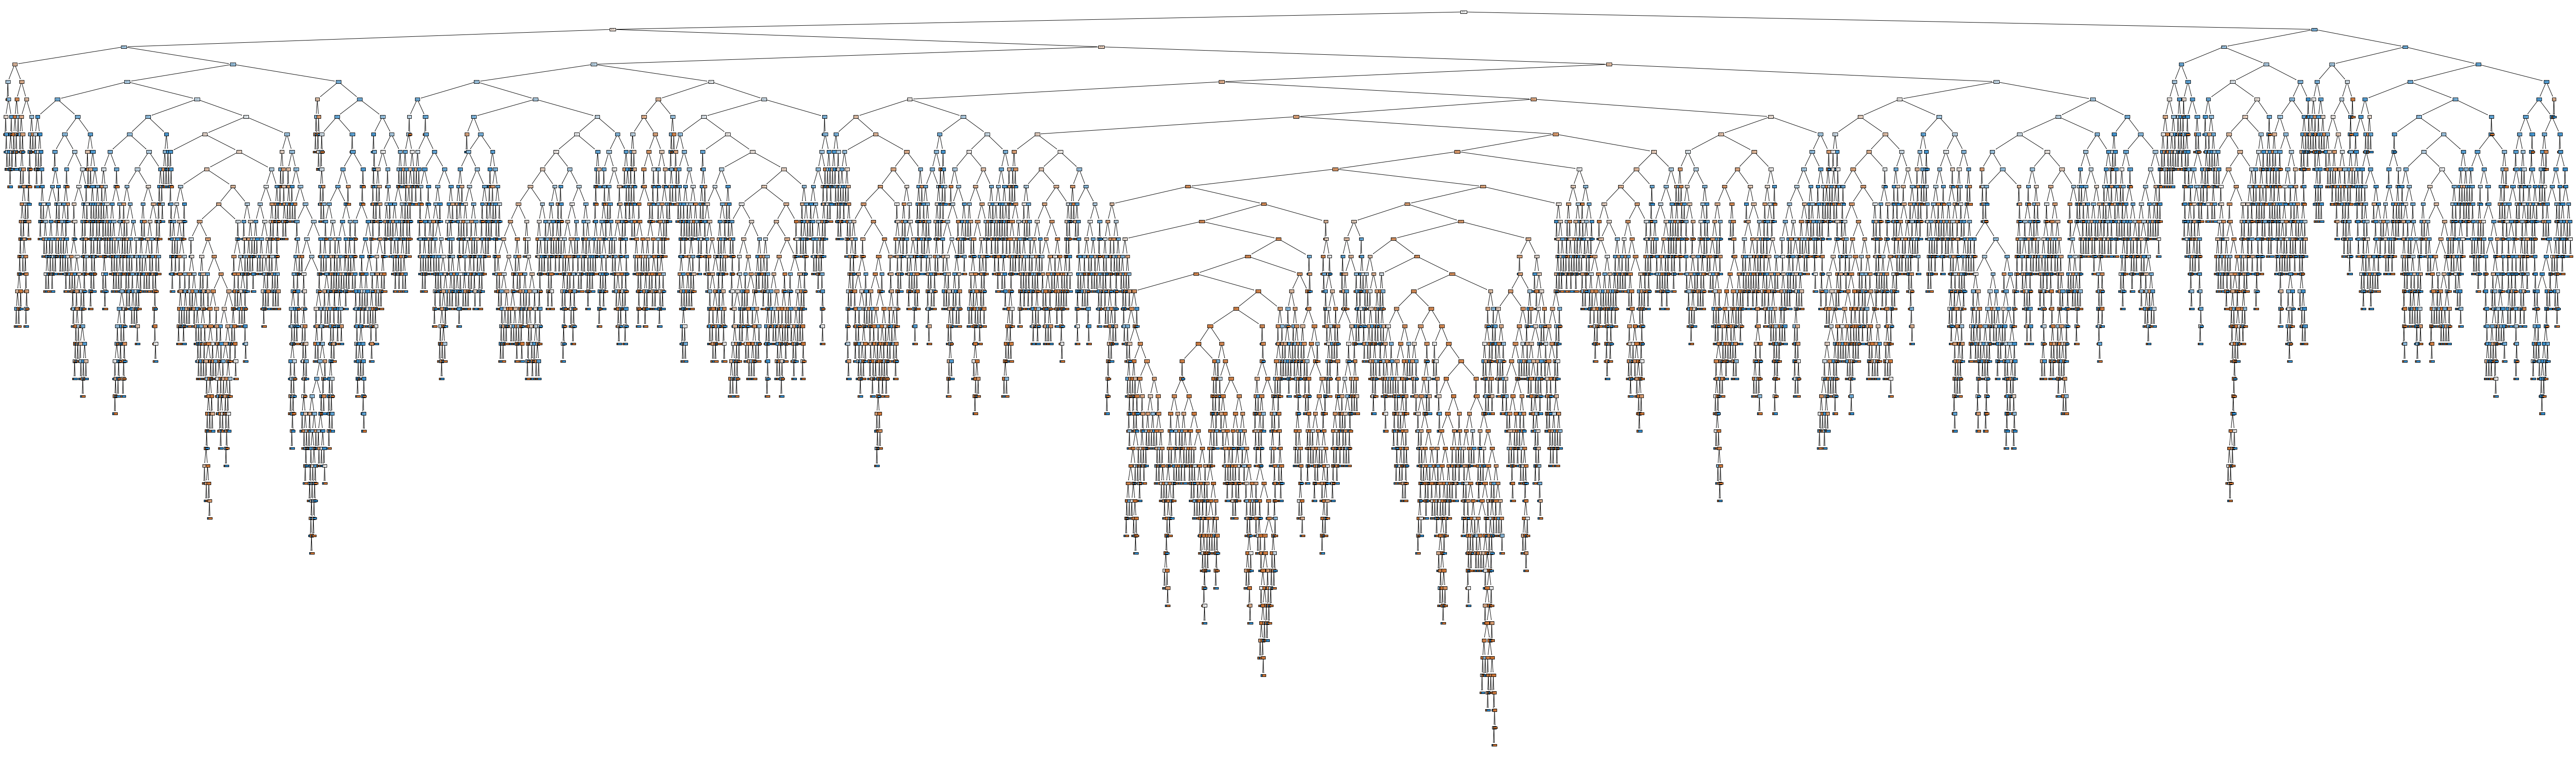

In [46]:
from sklearn import tree
# %matplotlib notebook
plt.figure(figsize=(100,30))
tree.plot_tree(dtc,filled=True)
plt.show()

Lookin at the output above, we can see that Decision Tree is way too saturated and in some cases the number of samples in a node is as low as 1. Hence some tuning is necessary. 
Note - This section is used only when we needed to find the parameters. There is no need to run this every run, hence it is commented out.

In [47]:
param_grid_dtc = {"max_depth":[10,15,20],"min_impurity_decrease":[0.2,0.1,0.05,0]}
param_grid_rf = {"n_estimators":[50,100,150,200],"max_features":[100,1000,10000,15000]}
param_grid_lr = {"C":[0.01, 0.1, 1, 10, 100, 1000],"max_iter":[100,500,1000,2000]}
param_grid_gnb = {"var_smoothing":[1e-9,1e-8,1e-10,1e-12]}
param_grid_gbc = {"n_estimators":[10,100,500,1000],"max_depth":[5,10,50,100],"learning_rate":[0.1,0.01,0.001]}
param_grid_cb = {"iterations":[100,500,1000],"learning_rate":[0.1,0.01,0.001]}


In [48]:
# grid_search_dtc = GridSearchCV(dtc, param_grid_dtc, cv=5, n_jobs=-1, return_train_score=True)
# grid_search_dtc.fit(X_train,y_train)
# print(f" The best parameter values are {grid_search_dtc.best_params_}.")

In [49]:
# grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, n_jobs=-1, return_train_score=True)
# grid_search_rf.fit(X_train,y_train)
# print(f" The best parameter values are {grid_search_rf.best_params_}.")

In [50]:
# grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5, n_jobs=-1, return_train_score=True)
# grid_search_lr.fit(X_train,y_train)
# print(f" The best parameter values are {grid_search_lr.best_params_}.")

In [51]:
# grid_search_gnb = GridSearchCV(gnb, param_grid_gnb, cv=5, n_jobs=-1, return_train_score=True)
# grid_search_gnb.fit(X_train,y_train)
# print(f" The best parameter values are {grid_search_gnb.best_params_}.")

In [52]:
# grid_search_gbc = GridSearchCV(gbc, param_grid_gbc, cv=5, n_jobs=-1, return_train_score=True)
# grid_search_gbc.fit(X_train,y_train)
# print(f" The best parameter values are {grid_search_gbc.best_params_}.")

In [53]:
# grid_search_cb = GridSearchCV(cb, param_grid_cb, cv=5, n_jobs=-1, return_train_score=True)
# grid_search_cb.fit(X_train,y_train)
# print(f" The best parameter values are {grid_search_cb.best_params_}.")

Once the best parameters were found for each of the classifiers, we ran all the models again with these parameters.

In [54]:
dtc = DecisionTreeClassifier(max_depth=10,min_impurity_decrease=0)
dtc.fit(X_train,y_train)
predict_dtc = dtc.predict(X_test)
predict_dtc_df = pd.DataFrame(predict_dtc,columns=['state']) # creating a dataframe of the results
final_dtc_df = pd.concat([col_df,predict_dtc_df],ignore_index=False, sort=False,axis=1)
final_dtc_df.to_csv("Results/output_dtc_tuned.csv",index=False)
result_dict["DecisionTree_Classifier_tuned"] = mean_std_cross_val_scores(dtc, X_train, y_train, cv=5, return_train_score=True)

In [55]:
pd.DataFrame(result_dict).T

,fit_time,score_time,test_score,train_score
Dummy_Classifer,0.002 (+/- 0.001),0.000 (+/- 0.000),0.501 (+/- 0.000),0.501 (+/- 0.000)
DecitionTree_Classifier,0.355 (+/- 0.033),0.004 (+/- 0.002),0.612 (+/- 0.005),1.000 (+/- 0.000)
GNB_Classifier,0.007 (+/- 0.001),0.002 (+/- 0.000),0.601 (+/- 0.008),0.602 (+/- 0.009)
LogisticR_Classifier,0.051 (+/- 0.004),0.001 (+/- 0.001),0.547 (+/- 0.006),0.548 (+/- 0.002)
RandomForest_Classifier,4.344 (+/- 0.185),0.069 (+/- 0.017),0.701 (+/- 0.006),0.786 (+/- 0.002)
GradBoost_Classifier,2.975 (+/- 0.139),0.009 (+/- 0.006),0.685 (+/- 0.005),0.692 (+/- 0.001)
RandomForest_Classifier_predict_proba_scaled,4.369 (+/- 0.233),0.067 (+/- 0.013),0.701 (+/- 0.006),0.786 (+/- 0.002)
GradBoost_Classifier_predict_proba,2.321 (+/- 0.112),0.004 (+/- 0.001),0.685 (+/- 0.005),0.692 (+/- 0.001)
RandomForest_Classifier_predict_proba,3.153 (+/- 0.209),0.055 (+/- 0.010),0.701 (+/- 0.006),0.786 (+/- 0.002)
CATBoost_Classifier,5.706 (+/- 0.351),0.003 (+/- 0.000),0.724 (+/- 0.007),0.800 (+/- 0.002)


In [56]:
#Random Forest tuned
rf = RandomForestClassifier(n_estimators = 150, max_depth=10,max_features=100, random_state=0)
rf.fit(X_train,y_train)

predict_rf = rf.predict(X_test)
predict_rf_df = pd.DataFrame(predict_rf,columns=['state']) # creating a dataframe of the results

final_rf_df = pd.concat([col_df,predict_rf_df],ignore_index=False, sort=False,axis=1)
final_rf_df.to_csv("Results/output_rf_tuned.csv",index=False)
result_dict["RandomForest_Classifier_tuned"] = mean_std_cross_val_scores(rf, X_train, y_train, cv=5, return_train_score=True)

In [57]:
pd.DataFrame(result_dict).T

,fit_time,score_time,test_score,train_score
Dummy_Classifer,0.002 (+/- 0.001),0.000 (+/- 0.000),0.501 (+/- 0.000),0.501 (+/- 0.000)
DecitionTree_Classifier,0.355 (+/- 0.033),0.004 (+/- 0.002),0.612 (+/- 0.005),1.000 (+/- 0.000)
GNB_Classifier,0.007 (+/- 0.001),0.002 (+/- 0.000),0.601 (+/- 0.008),0.602 (+/- 0.009)
LogisticR_Classifier,0.051 (+/- 0.004),0.001 (+/- 0.001),0.547 (+/- 0.006),0.548 (+/- 0.002)
RandomForest_Classifier,4.344 (+/- 0.185),0.069 (+/- 0.017),0.701 (+/- 0.006),0.786 (+/- 0.002)
GradBoost_Classifier,2.975 (+/- 0.139),0.009 (+/- 0.006),0.685 (+/- 0.005),0.692 (+/- 0.001)
RandomForest_Classifier_predict_proba_scaled,4.369 (+/- 0.233),0.067 (+/- 0.013),0.701 (+/- 0.006),0.786 (+/- 0.002)
GradBoost_Classifier_predict_proba,2.321 (+/- 0.112),0.004 (+/- 0.001),0.685 (+/- 0.005),0.692 (+/- 0.001)
RandomForest_Classifier_predict_proba,3.153 (+/- 0.209),0.055 (+/- 0.010),0.701 (+/- 0.006),0.786 (+/- 0.002)
CATBoost_Classifier,5.706 (+/- 0.351),0.003 (+/- 0.000),0.724 (+/- 0.007),0.800 (+/- 0.002)


In [58]:
#Logistic Regression tuned
lr = LogisticRegression(C=0.1,max_iter=100,random_state=1)
lr.fit(X_train,y_train)
predict_lr = lr.predict(X_test)
predict_lr_df = pd.DataFrame(predict_lr,columns=['state']) # creating a dataframe of the results

final_lr_df = pd.concat([col_df,predict_lr_df],ignore_index=False, sort=False,axis=1)
final_lr_df.to_csv("Results/output_lr_tuned.csv",index=False)
result_dict["LogisticR_Classifier_tuned"] = mean_std_cross_val_scores(lr, X_train, y_train, cv=5, return_train_score=True)

In [59]:
pd.DataFrame(result_dict).T

,fit_time,score_time,test_score,train_score
Dummy_Classifer,0.002 (+/- 0.001),0.000 (+/- 0.000),0.501 (+/- 0.000),0.501 (+/- 0.000)
DecitionTree_Classifier,0.355 (+/- 0.033),0.004 (+/- 0.002),0.612 (+/- 0.005),1.000 (+/- 0.000)
GNB_Classifier,0.007 (+/- 0.001),0.002 (+/- 0.000),0.601 (+/- 0.008),0.602 (+/- 0.009)
LogisticR_Classifier,0.051 (+/- 0.004),0.001 (+/- 0.001),0.547 (+/- 0.006),0.548 (+/- 0.002)
RandomForest_Classifier,4.344 (+/- 0.185),0.069 (+/- 0.017),0.701 (+/- 0.006),0.786 (+/- 0.002)
GradBoost_Classifier,2.975 (+/- 0.139),0.009 (+/- 0.006),0.685 (+/- 0.005),0.692 (+/- 0.001)
RandomForest_Classifier_predict_proba_scaled,4.369 (+/- 0.233),0.067 (+/- 0.013),0.701 (+/- 0.006),0.786 (+/- 0.002)
GradBoost_Classifier_predict_proba,2.321 (+/- 0.112),0.004 (+/- 0.001),0.685 (+/- 0.005),0.692 (+/- 0.001)
RandomForest_Classifier_predict_proba,3.153 (+/- 0.209),0.055 (+/- 0.010),0.701 (+/- 0.006),0.786 (+/- 0.002)
CATBoost_Classifier,5.706 (+/- 0.351),0.003 (+/- 0.000),0.724 (+/- 0.007),0.800 (+/- 0.002)


In [60]:
#Gradient Boosting
gbc = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01, max_depth=5, random_state=0)
gbc.fit(X_train,y_train)

predict_gbc = gbc.predict(X_test)
predict_gbc_df = pd.DataFrame(predict_gbc,columns=['state']) # creating a dataframe of the results

final_gbc_df = pd.concat([col_df,predict_gbc_df],ignore_index=False, sort=False,axis=1)
final_gbc_df.to_csv("Results/output_gbc_tuned.csv",index=False)
result_dict["GradBoost_Classifier_tuned"] = mean_std_cross_val_scores(gbc, X_train, y_train, cv=5, return_train_score=True)


In [61]:
pd.DataFrame(result_dict).T

,fit_time,score_time,test_score,train_score
Dummy_Classifer,0.002 (+/- 0.001),0.000 (+/- 0.000),0.501 (+/- 0.000),0.501 (+/- 0.000)
DecitionTree_Classifier,0.355 (+/- 0.033),0.004 (+/- 0.002),0.612 (+/- 0.005),1.000 (+/- 0.000)
GNB_Classifier,0.007 (+/- 0.001),0.002 (+/- 0.000),0.601 (+/- 0.008),0.602 (+/- 0.009)
LogisticR_Classifier,0.051 (+/- 0.004),0.001 (+/- 0.001),0.547 (+/- 0.006),0.548 (+/- 0.002)
RandomForest_Classifier,4.344 (+/- 0.185),0.069 (+/- 0.017),0.701 (+/- 0.006),0.786 (+/- 0.002)
GradBoost_Classifier,2.975 (+/- 0.139),0.009 (+/- 0.006),0.685 (+/- 0.005),0.692 (+/- 0.001)
RandomForest_Classifier_predict_proba_scaled,4.369 (+/- 0.233),0.067 (+/- 0.013),0.701 (+/- 0.006),0.786 (+/- 0.002)
GradBoost_Classifier_predict_proba,2.321 (+/- 0.112),0.004 (+/- 0.001),0.685 (+/- 0.005),0.692 (+/- 0.001)
RandomForest_Classifier_predict_proba,3.153 (+/- 0.209),0.055 (+/- 0.010),0.701 (+/- 0.006),0.786 (+/- 0.002)
CATBoost_Classifier,5.706 (+/- 0.351),0.003 (+/- 0.000),0.724 (+/- 0.007),0.800 (+/- 0.002)


In [62]:
# CATboost tuned
cb = CatBoostClassifier(iterations=500,learning_rate=0.1,random_state=0)
cb.fit(X_train,y_train)

predict_cb = cb.predict(X_test)
predict_cb_df = pd.DataFrame(predict_cb,columns=['state']) # creating a dataframe of the results

final_cb_df = pd.concat([col_df,predict_cb_df],ignore_index=False, sort=False,axis=1)
final_cb_df.to_csv("Results/output_catboost_tuned.csv",index=False)
result_dict["CATBoost_Classifier_tuned"] = mean_std_cross_val_scores(cb, X_train, y_train, cv=5, return_train_score=True)

0:	learn: 0.6809866	total: 27.1ms	remaining: 13.5s
1:	learn: 0.6713213	total: 38.4ms	remaining: 9.56s
2:	learn: 0.6618938	total: 47.7ms	remaining: 7.89s
3:	learn: 0.6542404	total: 59.6ms	remaining: 7.39s
4:	learn: 0.6471430	total: 70.2ms	remaining: 6.95s
5:	learn: 0.6413453	total: 80.5ms	remaining: 6.63s
6:	learn: 0.6358896	total: 91.1ms	remaining: 6.41s
7:	learn: 0.6314101	total: 99.9ms	remaining: 6.14s
8:	learn: 0.6268863	total: 110ms	remaining: 6.02s
9:	learn: 0.6228024	total: 118ms	remaining: 5.8s
10:	learn: 0.6192339	total: 127ms	remaining: 5.66s
11:	learn: 0.6157247	total: 138ms	remaining: 5.6s
12:	learn: 0.6127486	total: 148ms	remaining: 5.55s
13:	learn: 0.6099648	total: 159ms	remaining: 5.51s
14:	learn: 0.6074870	total: 168ms	remaining: 5.42s
15:	learn: 0.6050981	total: 179ms	remaining: 5.43s
16:	learn: 0.6026596	total: 188ms	remaining: 5.35s
17:	learn: 0.6003809	total: 198ms	remaining: 5.31s
18:	learn: 0.5983733	total: 213ms	remaining: 5.39s
19:	learn: 0.5963017	total: 224ms	r

167:	learn: 0.5176997	total: 1.93s	remaining: 3.81s
168:	learn: 0.5174512	total: 1.94s	remaining: 3.8s
169:	learn: 0.5171145	total: 1.96s	remaining: 3.79s
170:	learn: 0.5165760	total: 1.97s	remaining: 3.78s
171:	learn: 0.5162259	total: 1.98s	remaining: 3.77s
172:	learn: 0.5159847	total: 1.99s	remaining: 3.76s
173:	learn: 0.5156317	total: 2s	remaining: 3.75s
174:	learn: 0.5153268	total: 2.02s	remaining: 3.74s
175:	learn: 0.5149323	total: 2.03s	remaining: 3.73s
176:	learn: 0.5146944	total: 2.04s	remaining: 3.72s
177:	learn: 0.5143574	total: 2.05s	remaining: 3.71s
178:	learn: 0.5139749	total: 2.06s	remaining: 3.69s
179:	learn: 0.5136079	total: 2.07s	remaining: 3.68s
180:	learn: 0.5132549	total: 2.08s	remaining: 3.67s
181:	learn: 0.5128628	total: 2.09s	remaining: 3.66s
182:	learn: 0.5121520	total: 2.1s	remaining: 3.65s
183:	learn: 0.5118334	total: 2.12s	remaining: 3.63s
184:	learn: 0.5115878	total: 2.13s	remaining: 3.62s
185:	learn: 0.5113182	total: 2.14s	remaining: 3.61s
186:	learn: 0.511

328:	learn: 0.4724506	total: 3.86s	remaining: 2.01s
329:	learn: 0.4722513	total: 3.87s	remaining: 2s
330:	learn: 0.4719836	total: 3.89s	remaining: 1.99s
331:	learn: 0.4717473	total: 3.9s	remaining: 1.97s
332:	learn: 0.4715243	total: 3.92s	remaining: 1.96s
333:	learn: 0.4713403	total: 3.93s	remaining: 1.95s
334:	learn: 0.4710685	total: 3.95s	remaining: 1.94s
335:	learn: 0.4708941	total: 3.96s	remaining: 1.93s
336:	learn: 0.4707063	total: 3.97s	remaining: 1.92s
337:	learn: 0.4705029	total: 3.98s	remaining: 1.91s
338:	learn: 0.4702373	total: 3.99s	remaining: 1.9s
339:	learn: 0.4700434	total: 4s	remaining: 1.88s
340:	learn: 0.4698471	total: 4.02s	remaining: 1.87s
341:	learn: 0.4694761	total: 4.03s	remaining: 1.86s
342:	learn: 0.4692614	total: 4.04s	remaining: 1.85s
343:	learn: 0.4690220	total: 4.05s	remaining: 1.84s
344:	learn: 0.4688148	total: 4.06s	remaining: 1.83s
345:	learn: 0.4684746	total: 4.08s	remaining: 1.81s
346:	learn: 0.4682945	total: 4.09s	remaining: 1.8s
347:	learn: 0.4680438

489:	learn: 0.4375370	total: 5.79s	remaining: 118ms
490:	learn: 0.4373733	total: 5.8s	remaining: 106ms
491:	learn: 0.4372220	total: 5.81s	remaining: 94.5ms
492:	learn: 0.4370326	total: 5.83s	remaining: 82.8ms
493:	learn: 0.4368253	total: 5.84s	remaining: 71ms
494:	learn: 0.4364982	total: 5.86s	remaining: 59.1ms
495:	learn: 0.4363412	total: 5.87s	remaining: 47.3ms
496:	learn: 0.4362013	total: 5.88s	remaining: 35.5ms
497:	learn: 0.4358998	total: 5.89s	remaining: 23.7ms
498:	learn: 0.4357355	total: 5.91s	remaining: 11.8ms
499:	learn: 0.4356641	total: 5.92s	remaining: 0us
0:	learn: 0.6813988	total: 11.2ms	remaining: 5.61s
1:	learn: 0.6715650	total: 23.3ms	remaining: 5.8s
2:	learn: 0.6628739	total: 34.7ms	remaining: 5.75s
3:	learn: 0.6551080	total: 46.2ms	remaining: 5.73s
4:	learn: 0.6482661	total: 56.4ms	remaining: 5.58s
5:	learn: 0.6419852	total: 67.2ms	remaining: 5.54s
6:	learn: 0.6364409	total: 77.7ms	remaining: 5.47s
7:	learn: 0.6318693	total: 89.1ms	remaining: 5.48s
8:	learn: 0.627507

161:	learn: 0.5153790	total: 1.92s	remaining: 4s
162:	learn: 0.5149816	total: 1.93s	remaining: 3.98s
163:	learn: 0.5146640	total: 1.94s	remaining: 3.97s
164:	learn: 0.5144099	total: 1.95s	remaining: 3.96s
165:	learn: 0.5140591	total: 1.96s	remaining: 3.94s
166:	learn: 0.5136282	total: 1.97s	remaining: 3.93s
167:	learn: 0.5134017	total: 1.98s	remaining: 3.92s
168:	learn: 0.5130760	total: 1.99s	remaining: 3.9s
169:	learn: 0.5125905	total: 2s	remaining: 3.89s
170:	learn: 0.5123915	total: 2.02s	remaining: 3.88s
171:	learn: 0.5119628	total: 2.02s	remaining: 3.86s
172:	learn: 0.5117053	total: 2.04s	remaining: 3.85s
173:	learn: 0.5114048	total: 2.05s	remaining: 3.83s
174:	learn: 0.5110362	total: 2.06s	remaining: 3.82s
175:	learn: 0.5106039	total: 2.06s	remaining: 3.8s
176:	learn: 0.5102619	total: 2.08s	remaining: 3.79s
177:	learn: 0.5097905	total: 2.09s	remaining: 3.77s
178:	learn: 0.5093317	total: 2.1s	remaining: 3.76s
179:	learn: 0.5089378	total: 2.11s	remaining: 3.75s
180:	learn: 0.5085608

334:	learn: 0.4601226	total: 3.86s	remaining: 1.9s
335:	learn: 0.4598561	total: 3.87s	remaining: 1.89s
336:	learn: 0.4597123	total: 3.88s	remaining: 1.88s
337:	learn: 0.4594932	total: 3.9s	remaining: 1.87s
338:	learn: 0.4593036	total: 3.91s	remaining: 1.85s
339:	learn: 0.4589181	total: 3.92s	remaining: 1.84s
340:	learn: 0.4586220	total: 3.93s	remaining: 1.83s
341:	learn: 0.4583431	total: 3.94s	remaining: 1.82s
342:	learn: 0.4580659	total: 3.95s	remaining: 1.81s
343:	learn: 0.4577613	total: 3.96s	remaining: 1.79s
344:	learn: 0.4574415	total: 3.97s	remaining: 1.78s
345:	learn: 0.4572548	total: 3.98s	remaining: 1.77s
346:	learn: 0.4570044	total: 3.99s	remaining: 1.76s
347:	learn: 0.4566983	total: 4s	remaining: 1.75s
348:	learn: 0.4563959	total: 4.01s	remaining: 1.74s
349:	learn: 0.4561274	total: 4.02s	remaining: 1.72s
350:	learn: 0.4558323	total: 4.04s	remaining: 1.71s
351:	learn: 0.4553811	total: 4.05s	remaining: 1.7s
352:	learn: 0.4551543	total: 4.06s	remaining: 1.69s
353:	learn: 0.4548

1:	learn: 0.6714580	total: 22ms	remaining: 5.48s
2:	learn: 0.6621663	total: 32.3ms	remaining: 5.35s
3:	learn: 0.6543282	total: 43ms	remaining: 5.33s
4:	learn: 0.6476309	total: 53.7ms	remaining: 5.31s
5:	learn: 0.6418555	total: 64.3ms	remaining: 5.29s
6:	learn: 0.6362903	total: 75ms	remaining: 5.28s
7:	learn: 0.6317583	total: 85.2ms	remaining: 5.24s
8:	learn: 0.6273498	total: 95.8ms	remaining: 5.23s
9:	learn: 0.6230868	total: 107ms	remaining: 5.23s
10:	learn: 0.6189620	total: 119ms	remaining: 5.31s
11:	learn: 0.6154006	total: 131ms	remaining: 5.32s
12:	learn: 0.6123656	total: 143ms	remaining: 5.37s
13:	learn: 0.6097192	total: 155ms	remaining: 5.4s
14:	learn: 0.6071003	total: 172ms	remaining: 5.58s
15:	learn: 0.6043235	total: 186ms	remaining: 5.63s
16:	learn: 0.6022413	total: 198ms	remaining: 5.62s
17:	learn: 0.5995863	total: 209ms	remaining: 5.61s
18:	learn: 0.5975470	total: 223ms	remaining: 5.63s
19:	learn: 0.5956240	total: 234ms	remaining: 5.61s
20:	learn: 0.5937822	total: 248ms	remai

165:	learn: 0.5118992	total: 1.94s	remaining: 3.9s
166:	learn: 0.5114671	total: 1.95s	remaining: 3.89s
167:	learn: 0.5110368	total: 1.96s	remaining: 3.88s
168:	learn: 0.5106148	total: 1.97s	remaining: 3.86s
169:	learn: 0.5104087	total: 1.98s	remaining: 3.85s
170:	learn: 0.5099940	total: 1.99s	remaining: 3.83s
171:	learn: 0.5097018	total: 2s	remaining: 3.81s
172:	learn: 0.5092845	total: 2.01s	remaining: 3.8s
173:	learn: 0.5089086	total: 2.02s	remaining: 3.78s
174:	learn: 0.5085468	total: 2.03s	remaining: 3.77s
175:	learn: 0.5083172	total: 2.04s	remaining: 3.76s
176:	learn: 0.5079187	total: 2.05s	remaining: 3.74s
177:	learn: 0.5073974	total: 2.06s	remaining: 3.73s
178:	learn: 0.5069859	total: 2.07s	remaining: 3.71s
179:	learn: 0.5064549	total: 2.08s	remaining: 3.7s
180:	learn: 0.5059516	total: 2.09s	remaining: 3.69s
181:	learn: 0.5056636	total: 2.1s	remaining: 3.67s
182:	learn: 0.5053470	total: 2.11s	remaining: 3.66s
183:	learn: 0.5050983	total: 2.13s	remaining: 3.65s
184:	learn: 0.50463

325:	learn: 0.4603068	total: 3.71s	remaining: 1.98s
326:	learn: 0.4599551	total: 3.72s	remaining: 1.97s
327:	learn: 0.4595871	total: 3.73s	remaining: 1.96s
328:	learn: 0.4592558	total: 3.74s	remaining: 1.94s
329:	learn: 0.4589569	total: 3.75s	remaining: 1.93s
330:	learn: 0.4586728	total: 3.77s	remaining: 1.92s
331:	learn: 0.4583961	total: 3.78s	remaining: 1.91s
332:	learn: 0.4582113	total: 3.79s	remaining: 1.9s
333:	learn: 0.4579815	total: 3.8s	remaining: 1.89s
334:	learn: 0.4576850	total: 3.81s	remaining: 1.88s
335:	learn: 0.4573690	total: 3.82s	remaining: 1.86s
336:	learn: 0.4570789	total: 3.83s	remaining: 1.85s
337:	learn: 0.4567840	total: 3.84s	remaining: 1.84s
338:	learn: 0.4565804	total: 3.85s	remaining: 1.83s
339:	learn: 0.4563305	total: 3.87s	remaining: 1.82s
340:	learn: 0.4559959	total: 3.88s	remaining: 1.81s
341:	learn: 0.4556791	total: 3.89s	remaining: 1.8s
342:	learn: 0.4554393	total: 3.9s	remaining: 1.78s
343:	learn: 0.4552247	total: 3.91s	remaining: 1.77s
344:	learn: 0.45

490:	learn: 0.4199797	total: 5.66s	remaining: 104ms
491:	learn: 0.4197538	total: 5.68s	remaining: 92.3ms
492:	learn: 0.4195997	total: 5.69s	remaining: 80.8ms
493:	learn: 0.4192848	total: 5.7s	remaining: 69.2ms
494:	learn: 0.4190115	total: 5.71s	remaining: 57.7ms
495:	learn: 0.4188448	total: 5.72s	remaining: 46.2ms
496:	learn: 0.4186260	total: 5.74s	remaining: 34.6ms
497:	learn: 0.4184176	total: 5.75s	remaining: 23.1ms
498:	learn: 0.4182693	total: 5.76s	remaining: 11.5ms
499:	learn: 0.4180847	total: 5.77s	remaining: 0us
0:	learn: 0.6808936	total: 9.94ms	remaining: 4.96s
1:	learn: 0.6709017	total: 20.5ms	remaining: 5.1s
2:	learn: 0.6622371	total: 31.4ms	remaining: 5.2s
3:	learn: 0.6542018	total: 40.2ms	remaining: 4.99s
4:	learn: 0.6473330	total: 50.3ms	remaining: 4.98s
5:	learn: 0.6413384	total: 59.8ms	remaining: 4.92s
6:	learn: 0.6367402	total: 69.2ms	remaining: 4.87s
7:	learn: 0.6316641	total: 79.5ms	remaining: 4.89s
8:	learn: 0.6274190	total: 90.6ms	remaining: 4.94s
9:	learn: 0.623106

163:	learn: 0.5140440	total: 1.73s	remaining: 3.55s
164:	learn: 0.5137079	total: 1.75s	remaining: 3.54s
165:	learn: 0.5133511	total: 1.75s	remaining: 3.53s
166:	learn: 0.5128609	total: 1.77s	remaining: 3.52s
167:	learn: 0.5125070	total: 1.77s	remaining: 3.51s
168:	learn: 0.5122214	total: 1.78s	remaining: 3.5s
169:	learn: 0.5118394	total: 1.79s	remaining: 3.48s
170:	learn: 0.5113532	total: 1.8s	remaining: 3.47s
171:	learn: 0.5110384	total: 1.81s	remaining: 3.46s
172:	learn: 0.5107547	total: 1.82s	remaining: 3.45s
173:	learn: 0.5104606	total: 1.83s	remaining: 3.44s
174:	learn: 0.5101689	total: 1.84s	remaining: 3.42s
175:	learn: 0.5098221	total: 1.85s	remaining: 3.41s
176:	learn: 0.5094916	total: 1.86s	remaining: 3.4s
177:	learn: 0.5092060	total: 1.87s	remaining: 3.39s
178:	learn: 0.5088288	total: 1.88s	remaining: 3.38s
179:	learn: 0.5084966	total: 1.89s	remaining: 3.37s
180:	learn: 0.5082488	total: 1.9s	remaining: 3.35s
181:	learn: 0.5078672	total: 1.91s	remaining: 3.34s
182:	learn: 0.50

338:	learn: 0.4597888	total: 3.65s	remaining: 1.73s
339:	learn: 0.4595556	total: 3.66s	remaining: 1.72s
340:	learn: 0.4593183	total: 3.67s	remaining: 1.71s
341:	learn: 0.4590525	total: 3.68s	remaining: 1.7s
342:	learn: 0.4588095	total: 3.69s	remaining: 1.69s
343:	learn: 0.4585200	total: 3.7s	remaining: 1.68s
344:	learn: 0.4581888	total: 3.71s	remaining: 1.67s
345:	learn: 0.4578568	total: 3.72s	remaining: 1.66s
346:	learn: 0.4576115	total: 3.73s	remaining: 1.65s
347:	learn: 0.4572063	total: 3.74s	remaining: 1.64s
348:	learn: 0.4569663	total: 3.75s	remaining: 1.62s
349:	learn: 0.4566485	total: 3.77s	remaining: 1.61s
350:	learn: 0.4563253	total: 3.77s	remaining: 1.6s
351:	learn: 0.4559547	total: 3.79s	remaining: 1.59s
352:	learn: 0.4557063	total: 3.8s	remaining: 1.58s
353:	learn: 0.4554225	total: 3.81s	remaining: 1.57s
354:	learn: 0.4552597	total: 3.81s	remaining: 1.56s
355:	learn: 0.4548920	total: 3.82s	remaining: 1.55s
356:	learn: 0.4546014	total: 3.84s	remaining: 1.54s
357:	learn: 0.45

0:	learn: 0.6804554	total: 10.2ms	remaining: 5.07s
1:	learn: 0.6703510	total: 19.8ms	remaining: 4.94s
2:	learn: 0.6608513	total: 28.8ms	remaining: 4.77s
3:	learn: 0.6528157	total: 38.3ms	remaining: 4.74s
4:	learn: 0.6462743	total: 50.1ms	remaining: 4.96s
5:	learn: 0.6404100	total: 60.7ms	remaining: 5s
6:	learn: 0.6349028	total: 72.2ms	remaining: 5.09s
7:	learn: 0.6297317	total: 82.9ms	remaining: 5.1s
8:	learn: 0.6252838	total: 93.8ms	remaining: 5.12s
9:	learn: 0.6208858	total: 103ms	remaining: 5.04s
10:	learn: 0.6173276	total: 115ms	remaining: 5.1s
11:	learn: 0.6135228	total: 124ms	remaining: 5.06s
12:	learn: 0.6105935	total: 135ms	remaining: 5.07s
13:	learn: 0.6077770	total: 146ms	remaining: 5.07s
14:	learn: 0.6052214	total: 157ms	remaining: 5.07s
15:	learn: 0.6028617	total: 168ms	remaining: 5.07s
16:	learn: 0.6006453	total: 182ms	remaining: 5.17s
17:	learn: 0.5984150	total: 195ms	remaining: 5.21s
18:	learn: 0.5965574	total: 209ms	remaining: 5.28s
19:	learn: 0.5947293	total: 222ms	rem

163:	learn: 0.5089607	total: 1.75s	remaining: 3.58s
164:	learn: 0.5088007	total: 1.75s	remaining: 3.56s
165:	learn: 0.5084739	total: 1.76s	remaining: 3.55s
166:	learn: 0.5081132	total: 1.77s	remaining: 3.54s
167:	learn: 0.5078171	total: 1.78s	remaining: 3.53s
168:	learn: 0.5074172	total: 1.79s	remaining: 3.52s
169:	learn: 0.5070998	total: 1.8s	remaining: 3.5s
170:	learn: 0.5065972	total: 1.81s	remaining: 3.49s
171:	learn: 0.5063392	total: 1.82s	remaining: 3.48s
172:	learn: 0.5059654	total: 1.83s	remaining: 3.47s
173:	learn: 0.5057365	total: 1.84s	remaining: 3.45s
174:	learn: 0.5053638	total: 1.85s	remaining: 3.44s
175:	learn: 0.5051217	total: 1.86s	remaining: 3.43s
176:	learn: 0.5047238	total: 1.87s	remaining: 3.42s
177:	learn: 0.5044017	total: 1.88s	remaining: 3.41s
178:	learn: 0.5041248	total: 1.9s	remaining: 3.4s
179:	learn: 0.5035432	total: 1.91s	remaining: 3.39s
180:	learn: 0.5032665	total: 1.92s	remaining: 3.38s
181:	learn: 0.5027577	total: 1.93s	remaining: 3.37s
182:	learn: 0.50

328:	learn: 0.4560998	total: 3.46s	remaining: 1.8s
329:	learn: 0.4558007	total: 3.48s	remaining: 1.79s
330:	learn: 0.4555837	total: 3.49s	remaining: 1.78s
331:	learn: 0.4552046	total: 3.5s	remaining: 1.77s
332:	learn: 0.4549066	total: 3.51s	remaining: 1.76s
333:	learn: 0.4545993	total: 3.52s	remaining: 1.75s
334:	learn: 0.4543224	total: 3.53s	remaining: 1.74s
335:	learn: 0.4541165	total: 3.54s	remaining: 1.73s
336:	learn: 0.4538563	total: 3.56s	remaining: 1.72s
337:	learn: 0.4536300	total: 3.57s	remaining: 1.71s
338:	learn: 0.4533461	total: 3.58s	remaining: 1.7s
339:	learn: 0.4531234	total: 3.59s	remaining: 1.69s
340:	learn: 0.4529021	total: 3.6s	remaining: 1.68s
341:	learn: 0.4527087	total: 3.61s	remaining: 1.67s
342:	learn: 0.4525324	total: 3.63s	remaining: 1.66s
343:	learn: 0.4523200	total: 3.64s	remaining: 1.65s
344:	learn: 0.4520303	total: 3.65s	remaining: 1.64s
345:	learn: 0.4517664	total: 3.67s	remaining: 1.63s
346:	learn: 0.4514814	total: 3.68s	remaining: 1.62s
347:	learn: 0.45

0:	learn: 0.6803415	total: 10.9ms	remaining: 5.43s
1:	learn: 0.6702634	total: 22.5ms	remaining: 5.6s
2:	learn: 0.6614392	total: 32.6ms	remaining: 5.39s
3:	learn: 0.6536658	total: 42.4ms	remaining: 5.25s
4:	learn: 0.6472254	total: 54.2ms	remaining: 5.37s
5:	learn: 0.6409063	total: 65.2ms	remaining: 5.37s
6:	learn: 0.6354668	total: 75.7ms	remaining: 5.33s
7:	learn: 0.6308627	total: 86.8ms	remaining: 5.34s
8:	learn: 0.6259644	total: 97.7ms	remaining: 5.33s
9:	learn: 0.6220936	total: 108ms	remaining: 5.29s
10:	learn: 0.6184715	total: 119ms	remaining: 5.28s
11:	learn: 0.6151236	total: 127ms	remaining: 5.18s
12:	learn: 0.6120406	total: 137ms	remaining: 5.15s
13:	learn: 0.6088422	total: 147ms	remaining: 5.1s
14:	learn: 0.6060992	total: 157ms	remaining: 5.08s
15:	learn: 0.6035687	total: 166ms	remaining: 5.03s
16:	learn: 0.6012440	total: 175ms	remaining: 4.98s
17:	learn: 0.5994988	total: 184ms	remaining: 4.94s
18:	learn: 0.5974146	total: 197ms	remaining: 4.98s
19:	learn: 0.5951171	total: 208ms	

162:	learn: 0.5109953	total: 1.71s	remaining: 3.54s
163:	learn: 0.5105662	total: 1.72s	remaining: 3.53s
164:	learn: 0.5101230	total: 1.73s	remaining: 3.51s
165:	learn: 0.5098956	total: 1.74s	remaining: 3.5s
166:	learn: 0.5095196	total: 1.75s	remaining: 3.48s
167:	learn: 0.5090883	total: 1.76s	remaining: 3.47s
168:	learn: 0.5086803	total: 1.77s	remaining: 3.46s
169:	learn: 0.5083041	total: 1.78s	remaining: 3.45s
170:	learn: 0.5079997	total: 1.79s	remaining: 3.44s
171:	learn: 0.5077172	total: 1.8s	remaining: 3.43s
172:	learn: 0.5075127	total: 1.81s	remaining: 3.42s
173:	learn: 0.5071340	total: 1.82s	remaining: 3.4s
174:	learn: 0.5067993	total: 1.83s	remaining: 3.39s
175:	learn: 0.5064359	total: 1.83s	remaining: 3.38s
176:	learn: 0.5060681	total: 1.84s	remaining: 3.37s
177:	learn: 0.5058522	total: 1.85s	remaining: 3.35s
178:	learn: 0.5055544	total: 1.86s	remaining: 3.34s
179:	learn: 0.5049362	total: 1.88s	remaining: 3.33s
180:	learn: 0.5045020	total: 1.89s	remaining: 3.33s
181:	learn: 0.5

331:	learn: 0.4574467	total: 3.44s	remaining: 1.74s
332:	learn: 0.4572627	total: 3.46s	remaining: 1.73s
333:	learn: 0.4570004	total: 3.47s	remaining: 1.72s
334:	learn: 0.4567853	total: 3.48s	remaining: 1.71s
335:	learn: 0.4565945	total: 3.49s	remaining: 1.7s
336:	learn: 0.4562129	total: 3.5s	remaining: 1.69s
337:	learn: 0.4558954	total: 3.52s	remaining: 1.69s
338:	learn: 0.4557184	total: 3.53s	remaining: 1.68s
339:	learn: 0.4554509	total: 3.54s	remaining: 1.67s
340:	learn: 0.4551062	total: 3.55s	remaining: 1.66s
341:	learn: 0.4547953	total: 3.56s	remaining: 1.64s
342:	learn: 0.4544985	total: 3.57s	remaining: 1.63s
343:	learn: 0.4542243	total: 3.58s	remaining: 1.62s
344:	learn: 0.4539075	total: 3.58s	remaining: 1.61s
345:	learn: 0.4536714	total: 3.59s	remaining: 1.6s
346:	learn: 0.4534882	total: 3.6s	remaining: 1.59s
347:	learn: 0.4533523	total: 3.62s	remaining: 1.58s
348:	learn: 0.4531548	total: 3.63s	remaining: 1.57s
349:	learn: 0.4528493	total: 3.64s	remaining: 1.56s
350:	learn: 0.45

493:	learn: 0.4194669	total: 5.14s	remaining: 62.4ms
494:	learn: 0.4193013	total: 5.15s	remaining: 52ms
495:	learn: 0.4190664	total: 5.16s	remaining: 41.6ms
496:	learn: 0.4187908	total: 5.17s	remaining: 31.2ms
497:	learn: 0.4185791	total: 5.18s	remaining: 20.8ms
498:	learn: 0.4184010	total: 5.18s	remaining: 10.4ms
499:	learn: 0.4181990	total: 5.2s	remaining: 0us


In [63]:
pd.DataFrame(result_dict).T

,fit_time,score_time,test_score,train_score
Dummy_Classifer,0.002 (+/- 0.001),0.000 (+/- 0.000),0.501 (+/- 0.000),0.501 (+/- 0.000)
DecitionTree_Classifier,0.355 (+/- 0.033),0.004 (+/- 0.002),0.612 (+/- 0.005),1.000 (+/- 0.000)
GNB_Classifier,0.007 (+/- 0.001),0.002 (+/- 0.000),0.601 (+/- 0.008),0.602 (+/- 0.009)
LogisticR_Classifier,0.051 (+/- 0.004),0.001 (+/- 0.001),0.547 (+/- 0.006),0.548 (+/- 0.002)
RandomForest_Classifier,4.344 (+/- 0.185),0.069 (+/- 0.017),0.701 (+/- 0.006),0.786 (+/- 0.002)
GradBoost_Classifier,2.975 (+/- 0.139),0.009 (+/- 0.006),0.685 (+/- 0.005),0.692 (+/- 0.001)
RandomForest_Classifier_predict_proba_scaled,4.369 (+/- 0.233),0.067 (+/- 0.013),0.701 (+/- 0.006),0.786 (+/- 0.002)
GradBoost_Classifier_predict_proba,2.321 (+/- 0.112),0.004 (+/- 0.001),0.685 (+/- 0.005),0.692 (+/- 0.001)
RandomForest_Classifier_predict_proba,3.153 (+/- 0.209),0.055 (+/- 0.010),0.701 (+/- 0.006),0.786 (+/- 0.002)
CATBoost_Classifier,5.706 (+/- 0.351),0.003 (+/- 0.000),0.724 (+/- 0.007),0.800 (+/- 0.002)


In [64]:
base_cvscore = [0.613,0.601,0.547,0.701,0.685,0.724]
base_train = [1,0.602,0.548,0.786,0.692,0.800]
est = ["DecisionTree","GaussianNB","LogisticR","RandomForest","GradBoost","CatBoost"]

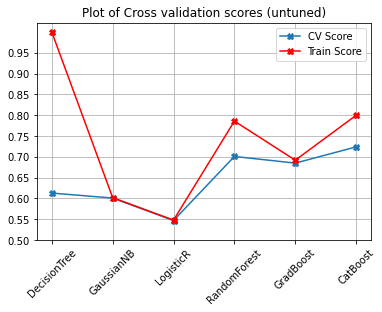

In [65]:
plt.plot(est,base_cvscore,"X-",label="CV Score")
plt.plot(est,base_train,"rX-",label="Train Score")

plt.xticks(rotation = 45)
plt.yticks(np.arange(0.5, 1, 0.05))
plt.grid()
plt.legend()
plt.title("Plot of Cross validation scores (untuned)")
plt.show()

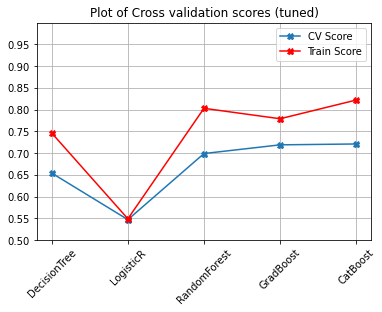

In [66]:
est = ["DecisionTree","LogisticR","RandomForest","GradBoost","CatBoost"]
tuned = [0.654,0.547,0.699,0.719,0.721]
tuned_train = [0.746,0.549,0.803,0.779,0.822]
plt.plot(est,tuned,"X-",label="CV Score")
plt.plot(est,tuned_train,"rX-",label="Train Score")
plt.ylim(0.5,1)
plt.yticks(np.arange(0.5, 1, 0.05))
plt.xticks(rotation = 45)
plt.grid()
plt.legend()
plt.title("Plot of Cross validation scores (tuned)")
plt.show()

### Discussion about Results

If we look at the plot of untuned CV scores, we can see that Decision Tree classifier was overfitted. Logistic regression model showed very low cross validation accuracy, which was unexpected since these models are known to work well for classificatio problems. The ensemble techniques showed the best results out of all classifiers tested. In particular Random Forest and CatBoost models were the best with CV score above 0.7 and relatively low/no overfitting.

Looking at the plot of tuned CV scores, we can see that after tuning the Decision Tree Classifier did not overfit the data. Moreover, the CV score also improved. We did not tune the hyperparameters for Gaussian Naive bayes classifier because the default parameters values were found to be the best. The perfomance of Random Forest classifier and CatBoost remained the same after tuning. However, the performance of Gradient Boosting Classifier increased after the tuning.

### Kaggle Scores

We found out that the Kaggle score is different than CV score we calculate after model training. Kaggle uses Area under curve to score the results. Hence, if instead 0 and 1 as classification, we submitted the submission with probabilities of state being active or 1, the results were much better. For this we used `predict_proba()` instead of `predict()`. However, the competition clearly asked for binary classification, we did not use this method.

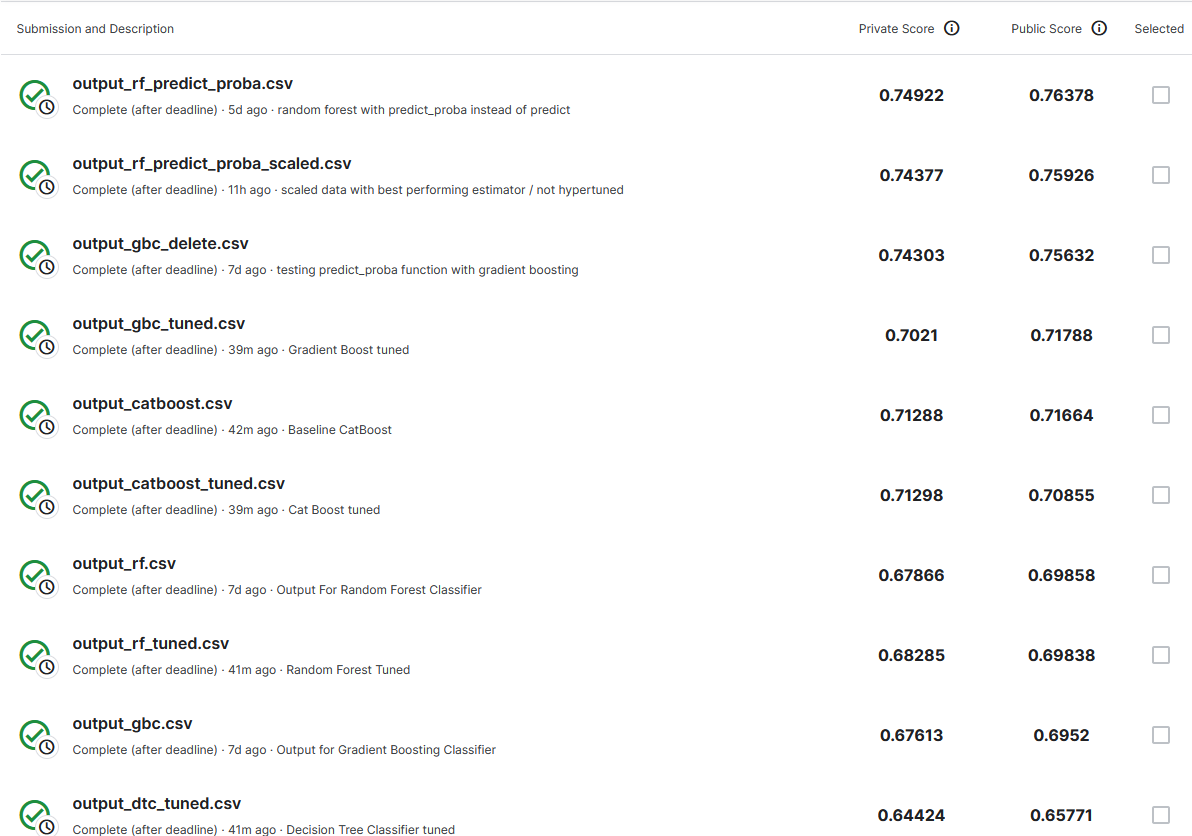

The first two submission that were obtained using `predict_proba()` recieved better scores than the other results that were obtained by using `predict()`.

### Pratt method results

In the preprocessing section, we discussed about the `Pratt method` of preprocessing. Basically instead of 13 features, we created dataframes of 91 features and used these to make classification.

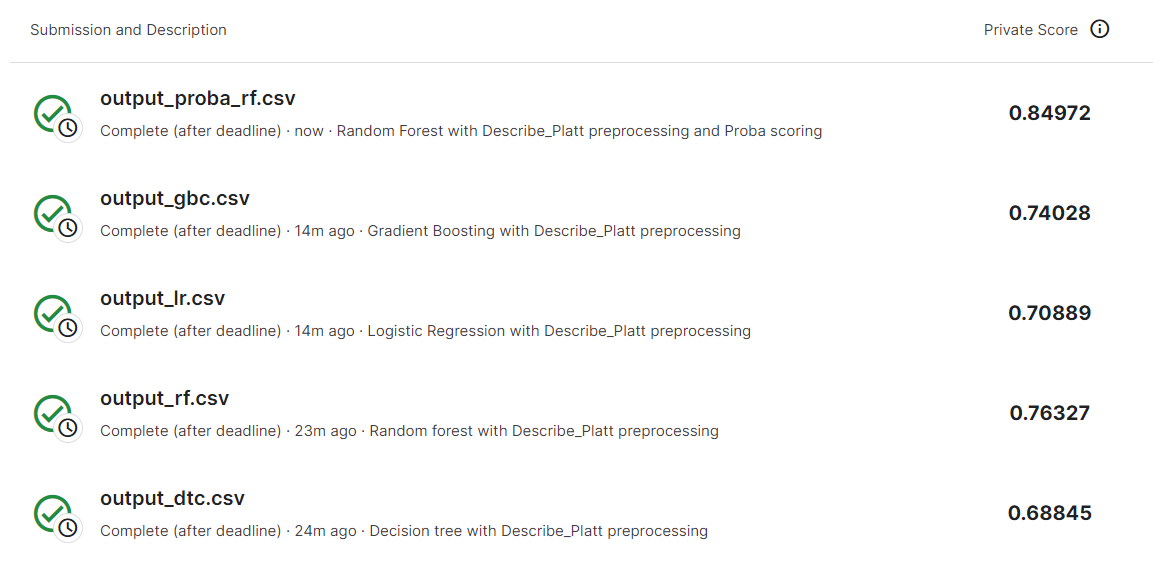

As we can see the baseline scores without hyperparameter tuning were similar. However, the Platt preprocessed data was used in conjuction with `predict_proba()`, we got the best score of 0.849. Unfortunately, we could not explore further this pipeline before the deadline of the project. Additionally using a dataframe with 91 features and more than 1 million data points was computationally expensive as well.

### Conclusion and Future Work

In conclusion, we implemeted different methods of data analysis and preprocessing learnt during the lecture periods. The ensemble techniques are a bit better than the normal/standard classifiers.

For future work, we would like to test different hyperparameter. Moreover, we would also like to try different libraries and models to see if the results are different or better in any way. Additionally, we simply used the mean to group the 60 second sensor data. We would like to explore other possibilities to group the sequence and see the affect on the state predition.